<a href="https://colab.research.google.com/github/imiled/DL_Tools_For_Finance/blob/master/BDL_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Install dependencies

In [ ]:
!pip install tensorflow-gpu==2.0.0 > /dev/null 2>&1
!pip install tensorflow-probability==0.8.0 > /dev/null 2>&1

#### Imports 


In [ ]:
%matplotlib inline
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import tensorflow_probability as tfp
tfd = tfp.distributions

# datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

# Bayesian Deep Learning

![](https://alexgkendall.com/assets/images/blog_uncertainty/uncertainty_types.jpg)
<sub>_Illustrating the difference between aleatoric and epistemic uncertainty for semantic segmentation. You can notice that aleatoric uncertainty captures object boundaries where labels are noisy. The bottom row shows a failure case of the segmentation model, when the model is unfamiliar with the footpath, and the corresponding increased epistemic uncertainty_</sub>


Generally speaking, conventional neural networks (NN) are well designed to calculate point estimates of any quantity of interest. However, NN can not deal with uncertainties on their own, and require of new tools to become a truly probabilistic framework. 

In this notebook, we will see how Bayesian inference methods can help us to fix some of the shortcomings of deep learning, in particular, those related with the notion of uncertainty and confidence about the network predictions. 

We will learn about the following topics:

1. Why should I care about uncertainty? 
2. Bayesian statistics <br> 
    2.1 Bayes Formula  <br>
    2.2 Gaussian Processes  <br>
    2.3 Optimization <br> 
      2.3.1 Variational Inference  <br>
      2.3.2 Monte Carlo Methods <br>
    
Break    
    
3. Bayesian Deep Learning  <br> 
    3.1 Case 1: No Uncertainty <br>
    3.2 Case 2: Aleatoric Uncertainty <br>
    3.3 Case 3: Epistemic Uncertainty <br>
    3.4 Case 4: Aleatoric & Epistemic Uncertainty  <br>
    3.5 Case 5: DropOut <br> 
4. Convolutional BNN. <br> 

## Why should I care about uncertainty?

Measurement uncertainty is critical in a wide range of fields such as risk assessment, decision making, physics or life science. In such fields it is
quite important to quantify our confidence about the models’ predictions.

In this sense, uncertainty provides us with a mechanism for discerning what our model knows or ignores, and it helps us to bring insights into the model when it fails -where am I not certain?.

Imagine the next scenario. We train our model on MNIST and learn to classify
numbers. Now we try to predict over images the model has never observed before (fashion MNIST, for example). How the model behaves and what should be the desired behaviour for a model under these cases? 

_Maybe we should return a prediction but with evidences that the predicted data lies outside of the data distribution the model was trained on. I.e. we want
a model that displays a high level of uncertainty with such
inputs_

__Ex. Train MNIST. Predict with Fashion MNIST dataset. What do you observe?__

In [ ]:
def read_mnist(fashion=False):
    """
    Auxiliar function to read mnist
    """
    nb_classes = 10
    img_rows, img_cols = 28, 28
    input_shape = (img_rows, img_cols, 1)
    if fashion:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Prepare dataset
    x_train = x_train / 255
    x_test = x_test / 255
    return x_train, x_test, y_train, y_test
    

In [ ]:
def plot_mnist(x_test, y, num_figures=15, N=10000, num_columns=5):
    """
    Plot mnist test with predictions
    """
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(N, size=num_figures, replace=False)):
        ax = figure.add_subplot(np.ceil(num_figures / num_columns), num_columns, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test[index]), cmap=plt.get_cmap('gray'))
        predict_index = np.argmax(y[index])
        # Set the title for each image
        ax.set_title("{}".format(predict_index))

In [ ]:
def plot_sample_mnist(x_train):
    """
    plot 4 images as gray scale
    """
    img_rows, img_cols = 28, 28
    x = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    for i, j in enumerate([221, 222, 223, 224]):
        plt.subplot(j)
        plt.imshow(x[i], cmap=plt.get_cmap('gray'))
    plt.show()

11493376/11490434 [==============================] - 1s 0us/step


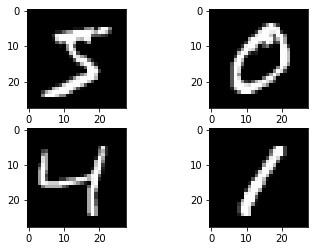

In [ ]:
# mnist
x_train, x_test, y_train, y_test = read_mnist()
plot_sample_mnist(x_train)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3017 - accuracy: 0.9122 - val_loss: 0.1470 - val_accuracy: 0.9560
Epoch 2/5
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1476 - accuracy: 0.9568 - val_loss: 0.1066 - val_accuracy: 0.9677
Epoch 3/5
60000/60000 [==============================] - 6s 100us/sample - loss: 0.1090 - accuracy: 0.9669 - val_loss: 0.0900 - val_accuracy: 0.9728
Epoch 4/5
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0890 - accuracy: 0.9725 - val_loss: 0.0855 - val_accuracy: 0.9724
Epoch 5/5
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0761 - accuracy: 0.9760 - val_loss: 0.0792 - val_accuracy: 0.9755
10000/1 - 1s - loss: 0.0409 - accuracy: 0.9755


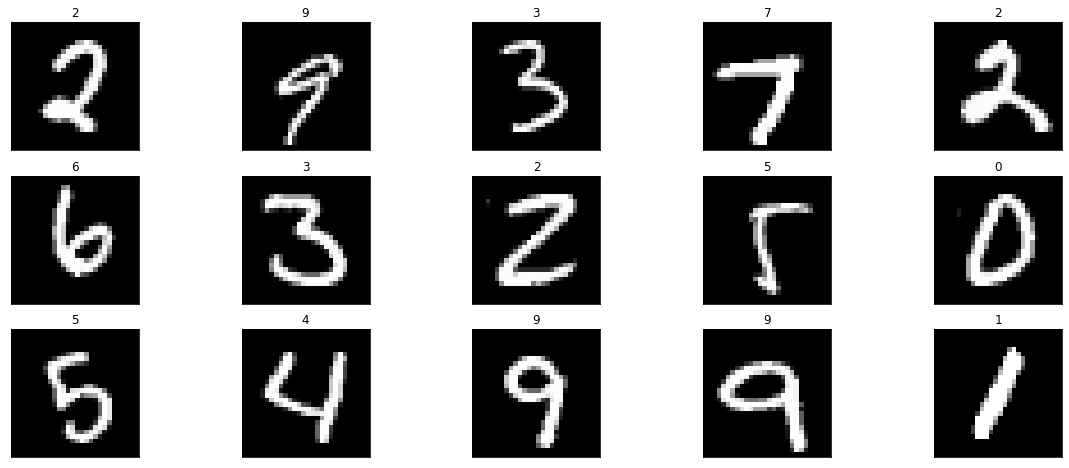

In [ ]:
# Parameters
img_rows, img_cols = 28, 28
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
batch_size = 128
nb_epoch = 1

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

model.evaluate(x_test,  y_test, verbose=2)

# Prediction
y = model.predict(x_test)

# Plot predictions
plot_mnist(x_test, y)

4423680/4422102 [==============================] - 0s 0us/step


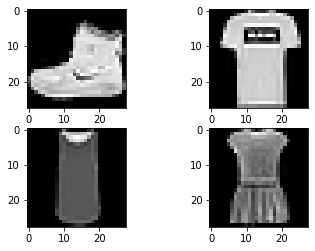

In [ ]:
# fashion mnist
fashion_x_train, fashion_x_test, fashion_y_train, fashion_y_test = read_mnist(fashion=True)
plot_sample_mnist(fashion_x_train)


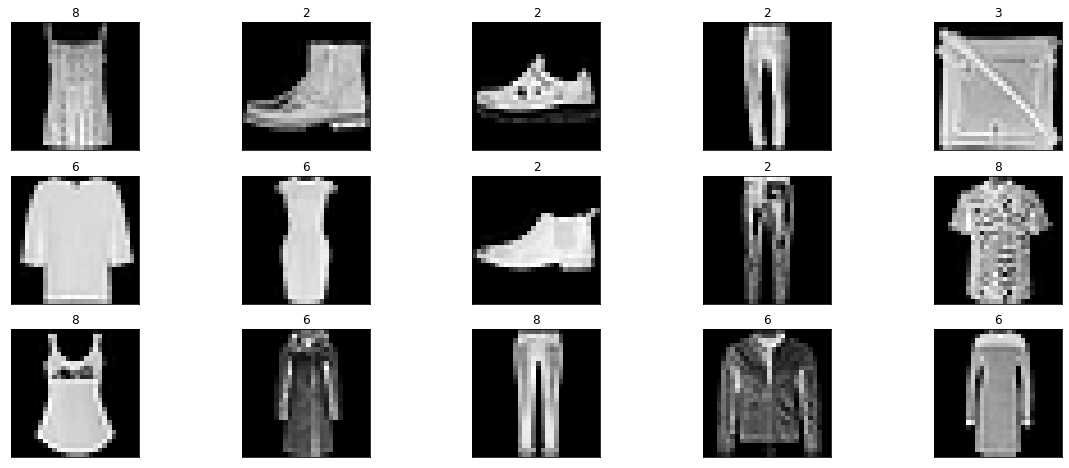

In [ ]:
fashion_y = model.predict(fashion_x_test)
# Plot predictions
plot_mnist(fashion_x_test, fashion_y)

## Bayesian Statistics


### Bayes Formula


Bayes Theorem provides a principled way for calculating a conditional probability. In simple terms, Bayes theorem computes the probability of a hypothesis (or parameter) $H$ based on its prior probability, the probabilities of observing various data $D$ --source of information in this case-- given the hypothesis, and the observed data itself. 

*Note how the unknown parameter o hypothesis $h$ is now a random variable, in contrast with the typical 
frequentist approach

In the discrete domain, Bayes Formula adopts the following expression:

$$P(h|D) = \frac{P(D|h) P(h)}{P(D)}$$

where

$P(h|D)$: denotes the posterior probability of the hypothesis (the thing we want to calculate). It summarises the information about $h$ after observing the data $D$.

$P(h)$: is the prior probability of the hypothesis. If we do not have any prior information about the hypothesis being tested, it can be assigned as a uniform probability

$P(D)$: is the probability of the data. According to the Law of total probability, $P(D)$ can be expressed as follows:

$$P(D) = \sum_n P(D|h_n) P(h_n) $$

with $P(h_n)$ the probability of each hypothesis. Note how this quantity is independent of the parameter or hypothesis $h$.


__Ex: Implement the discrete Bayes Formula__

In [ ]:
class bayes_discrete():
    def __init__(self, evidence, queried_state, likelihood_dict, priors=None):
        self.evidences = list(likelihood_dict.keys())
        self.evidence = evidence
        self.states = list(likelihood_dict[self.evidences[0]].keys())
        self.state = queried_state
        self.n_states = len(self.states)
        self.probabilities = np.array([likelihood_dict[self.evidence][s] for s in self.states])
        self.prior(priors)
        self.likelihood = likelihood_dict[evidence][queried_state]
    
    def prior(self, p=None):
        if p:
            self.prs = np.array([p[s] for s in self.states])
            self.pr = p[self.state]
        else:
            self.prs = np.ones(self.n_states) / self.n_states
            self.pr = 1. / self.n_states
    
    def posterior(self):
        total_probability = self.total_probability()
        posterior = self.likelihood * self.pr / total_probability
        return posterior
    
    def total_probability(self):
        total = np.sum(self.probabilities * self.prs)
        return total

__Ex. Calculate bayes theorem for a diagnostic test__
Consider a human population that may or may not have cancer (Cancer is True or False) and a medical test that returns positive or negative for detecting cancer (Test is Positive or Negative), e.g. like a mammogram for detecting breast cancer. If a patient has the test and it comes back positive, what is the probability that the patient has cancer? Consider with a true positive rate or sensitivity of 85%. That is, of all the people who have cancer and are tested, 85% of them will get a positive result from the test. Besides that, we can assume the probability of breast cancer is low, and use a contrived value of one person in 5,000, or (0.0002) 0.02%. Testing negative result (Test=Negative) when the patient does not have cancer (Cancer=False) is associted with the value of 95%.

In [ ]:
cancer_problem = bayes_discrete('positive', 'cancer', 
                                {'positive': {'cancer': 0.85, 'NotCancer': 0.05}, 
                                 'negative': {'cancer': 0.15, 'NotCancer': 0.95}},
                               {'cancer': 0.0002, 'NotCancer': 0.9998})
cancer_problem.posterior()


0.0033891547049441782

It is a terrible diagnostic test indeed!

__Ex. The cookie problem__
Suppose there are two bowls of cookies. Bowl 1 contains 30 vanilla
cookies and 10 chocolate cookies. Bowl 2 contains 20 of each.
Now suppose you choose one of the bowls at random and, without looking, select a
cookie at random. The cookie is vanilla. What is the probability that it came from Bowl
1?

In [ ]:
cookie_problem = bayes_discrete('vanilla', 'bowl1', 
                                {'vanilla': {'bowl1': 3. / 4, 'bowl2': 1. / 2}, 
                                 'chocolate': {'bowl1': 1. / 4, 'bowl2': 1. / 2}})
cookie_problem.posterior()

0.6

### Continuous case of the teorem & Gaussian Processes


A similiar expression can be obtained for the continuous case:

$$p(h|D) = \frac{f(D|h) f(h)}{\int f(D|h) f(h) dh}$$

but now we work in terms of density functions and replace sums by integrals.

The term $f(D|h)$ is called the likelihood function $L(h)$. As the denominator is independent of the hypothesis, the density of the posterior distribution is  proportional to the product of the likelihood and the density of the prior distribution

$$f(h | D) \propto f (D | h)f (h) = L(h) f (h)$$

Under a uniform prior, we can observe that the posterior mode 
$$arg max_h f (h| D)$$ 

equals the common maximum likelihood estimation (MLE). 

In fact, seeking the hypothesis with the maximum posterior probability --that is, the best one which explained the observed data -- implies the resolution of this optimization problem known as  maximum a posteriori or MAP. 

Fitting models like linear regression for predicting a numerical value (as in the next sections), and logistic regression for binary classification can be framed and solved under the MAP probabilistic framework.

Let's see in practice how all this works taken the Gaussian Processes as an example.

__Gaussian Processes.__The key idea behind GPs is that a function can be modeled using an infinite dimensional multivariate Gaussian distribution. In other words, every point in the input space is associated with a random variable and the joint distribution of these is modeled as a multivariate Gaussian. 

The multivariate Gaussian distribution is defined by a mean vector $\mu$ and a covariance matrix $\Sigma$. The mean vector $\mu$ describes the expected value of the distribution. Each of its components describes the mean of the corresponding dimension. $\Sigma$ models the variance along each dimension and determines how the different random variables are correlated. The covariance matrix is always symmetric and positive semi-definite. The diagonal of $\Sigma$ consists of the variance $\sigma_i^2$ of the $i$-th random variable. And the off-diagonal elements $\sigma_{ij}$ describe the correlation between the $i$-th and $j$-th random variable. The covariance matrix $\Sigma$ describes the shape of the distribution.

The covariance matrix $\Sigma$ is determined by its covariance function $k$, which is often also called the kernel of the Gaussian process.

__Ex.__ To gain intuition about what a distribution over functions means, lets start with a simpler case: a unit 2D Gaussian.

$$\begin{pmatrix} y_0 \\ y_1 \end{pmatrix} \sim N \begin{pmatrix} \begin{pmatrix} 0\\ 0 \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \end{pmatrix}$$

If we just sample from the distribution, then we will have two values which we can plot on an graph. Let’s do this 10 times, putting the first value at x=0 and the second at x=1 and then drawing a line between them.

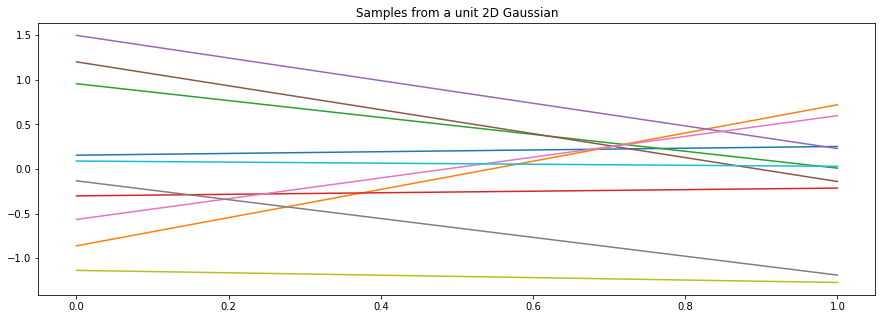

In [ ]:
def plot_unit_gaussian_samples(D):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    xs = np.linspace(0, 1, D)
    p = plt.figure(figsize=(15, 5))
    for color in colors:
        ys = np.random.multivariate_normal(np.zeros(D), np.eye(D))
        plt.plot(xs, ys, color=color)
    plt.title('Samples from a unit {}D Gaussian'.format(D))

plt.show(plot_unit_gaussian_samples(2))

It looks like a sampled of 10 linear functions, doesnot it? What if we now use a 20-dimensional Gaussian, joining each of the sampled points in order?

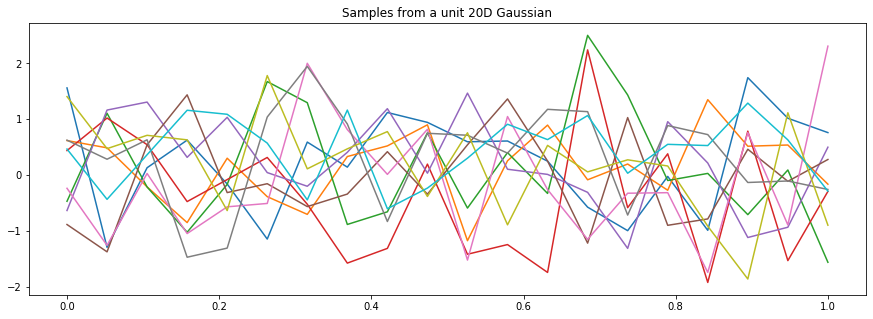

In [ ]:
plt.show(plot_unit_gaussian_samples(20))

These definitely look like functions, but too noisy functions...

Changing the mean does not seem to reduce the noise, but just the overall trend. What about the covariance? To get smoothness in our example, two closed points should be  similar to each other, that is, the random variables corresponding to two nearby points should have similar values when sampled under their joint distribution. This means in practice higher covariance values.

To see that, let us implement the squared exponential kernel:

In [ ]:
def k(xs, ys, sigma=1, l=1):
    """Squared Exponential kernel as above but designed to return the whole
    covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
    Also with two parameters which are discussed at the end."""

    # Pairwise difference matrix.
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

def m(x):
    """The mean function. As discussed, we can let the mean always be zero."""
    return np.zeros_like(x)

Text(0, 0.5, "x'")

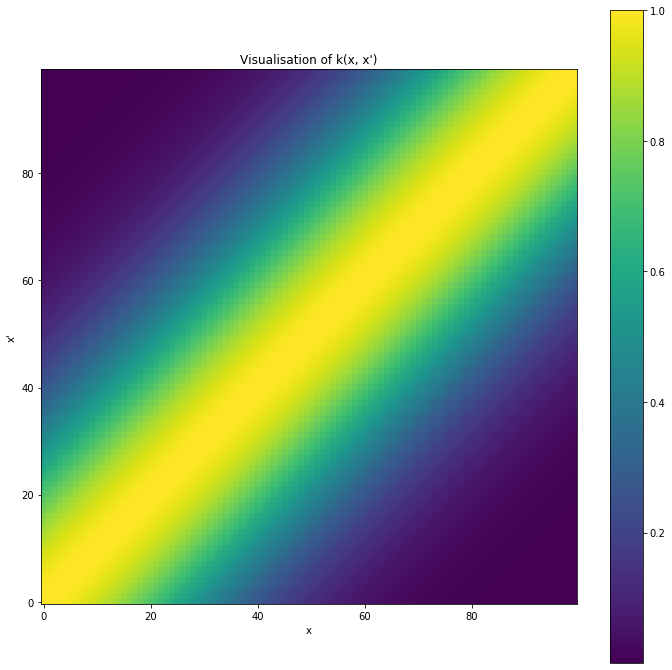

In [ ]:
N = 100
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
d = k(x, y)

p = plt.figure(figsize=(12,12
                       ))
im = plt.imshow(d, interpolation='nearest', origin='lower') 
plt.colorbar()
plt.x_lim=(-2, 2), 
plt.y_lim=(-2, 2),
plt.title("Visualisation of k(x, x')")
plt.xlabel('x')
plt.ylabel(r"x'")

If we sample the points using this new covariance matrix, we get the following:

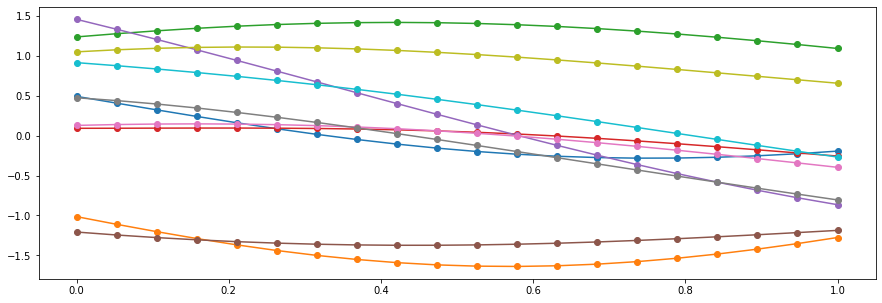

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
p = plt.figure(figsize=(15, 5))
D = 20
xs = np.linspace(0, 1, D)
for color in colors:
    ys = np.random.multivariate_normal(m(xs), k(xs, xs))
    plt.plot(xs, ys, 'o', color=color)
    plt.plot(xs, ys, color=color)

plt.show(p)

Let’s use more dimensions:

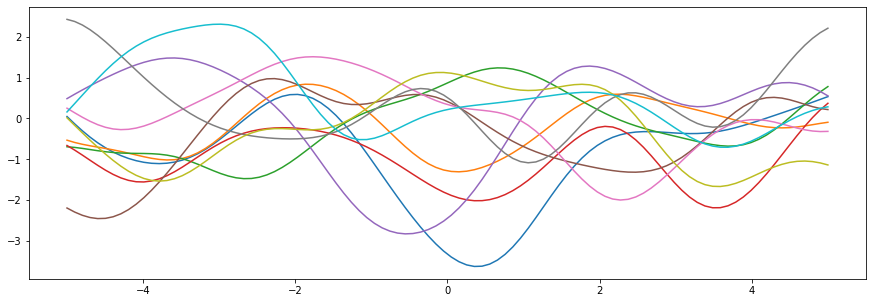

In [ ]:
n = 100
xs = np.linspace(-5, 5, n)
K = k(xs, xs)
mu = m(xs)

p = plt.figure(figsize=(15, 5))

for color in colors:
    ys = np.random.multivariate_normal(mu, K)
    plt.plot(xs, ys, color=color)
plt.show()

As we can appreciate from the plot, we get something that looks like a distribution over functions. 

__Doing regression with the help of Bayes Theorem.__ Let's try to apply all this learnings to train and predict the following curve:

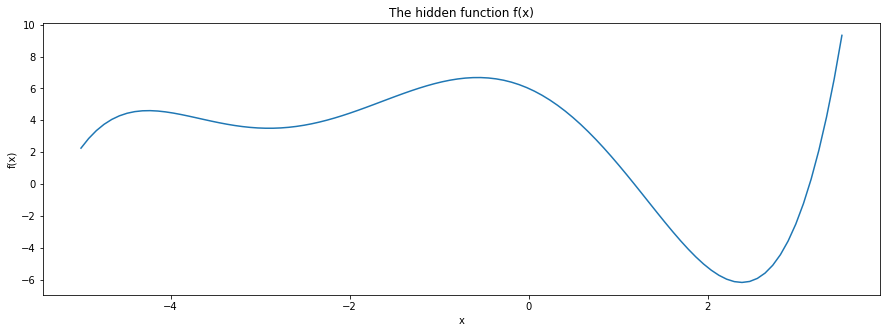

In [ ]:
# coefs[i] is the coefficient of x^i
coefs = [6, -2.5, -2.4, -0.1, 0.2, 0.03]

def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total

xs = np.linspace(-5.0, 3.5, 100)
ys = f(xs)

p = plt.figure(figsize=(15, 5)) 
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('The hidden function f(x)')
plt.plot(xs, ys)
plt.show()

Remember that we want to model $p(y|x)$ using a multivariate normal:

$$p(y|x)=N(y|m(x),K)$$

where $K=k(x,x)$ and $m(x)=0$. $x$ and $y$ are respectively the input data and the output.

Given some new points $x^*$ (hypothesis), we want to predict $y^∗=f(x^∗)$ taken as information the training data (Bayes!).
Recalling the definition of GP, the join distribution of $y$ and $y^*$ should be:

$$\begin{pmatrix} y \\ y^* \end{pmatrix} \sim N \begin{pmatrix} \begin{pmatrix} m(x)\\ m(x^*) \end{pmatrix} \begin{pmatrix} K & K_* \\ K^T_* & K_{**} \end{pmatrix} \end{pmatrix}$$

from where we can derive by Bayes the following expressions:

$$p(y∗|x∗,x,y)=N(y^∗|\mu^∗,\Sigma^∗)$$
$$\mu=m(x^∗)+K^{T∗}K^{−1}(y−m(x))$$
$$\Sigma=K_{∗∗}−K^{T}_{∗}K^{−1}K_∗$$

And that's all! Implement the posterior and take some samples from it. What do you observe?

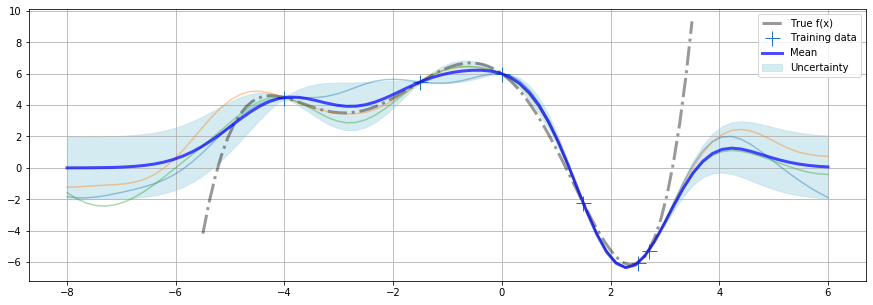

In [ ]:
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
y_obs = f(x_obs)

x_s = np.linspace(-8, 6, 80)
K = k(x_obs, x_obs)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s)

K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K))

mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs))
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)
stds = np.sqrt(Sigma_s.diagonal())

x_true = np.linspace(-5.5, 3.5, 80)
y_true = f(x_true)

# Figure
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(x_true, y_true, '-.', linewidth=3, color='black', alpha=0.4,
       label='True f(x)')
axs.plot(x_obs, y_obs, '+', linewidth=3, markersize=15, label='Training data')
axs.fill_between(x_s, mu_s + 2 * stds, mu_s - 2 * stds, 
                     color='lightblue', alpha=0.5, label='Uncertainty') 
for color in colors[:3]:
    y_s = np.random.multivariate_normal(mu_s, Sigma_s)
    plt.plot(x_s, y_s, color=color, alpha=0.4)
axs.plot(x_s, mu_s, linewidth=3, color='blue', alpha=0.7,
         label='Mean')
axs.grid()
axs.legend(loc='best')


__Working on Tensorflow.__ We can implement the above Gaussian process with the help of [TensorFlow Probability](https://github.com/tensorflow/probability) (TFP). TFP is an open source Python library built on top of TensorFlow that makes it easy to combine probabilistic models and deep learning.

Included in TFP, the method tfd.GaussianProcess for instance allows us to draw joint samples from a GP prior or optimize kernel parameters via maximum marginal likelihood. In the case of regression models, we can use the derived method [tfd.GaussianProcessRegressionModel](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel)

__Ex.__ Above, we have used the kernel with default parameters, which are unlikely to be good. Instead, we can train the kernel hyperparameters on the data, as in the next example.

In [ ]:
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [ ]:
class GPRExpQuad(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.amplitude = tf.Variable(np.float32(0.0), name='amplitude')
        self.length_scale = tf.Variable(np.float32(0.0), name='length_scale')
        self.observation_noise_variance = tf.Variable(np.float32(-5.0), name='obs_noise_variance')

    @property
    def kernel(self):
        return psd_kernels.ExponentiatedQuadratic(tf.exp(self.amplitude), tf.exp(self.length_scale))

    def nll_for_train(self, x_obs, y_obs):
        gp = tfd.GaussianProcess(
            kernel=self.kernel,
            index_points=x_obs,
            observation_noise_variance=tf.exp(self.observation_noise_variance))
        return -tf.reduce_mean(gp.log_prob(y_obs))

    def gprm(self, x_obs, y_obs, x):
        return tfd.GaussianProcessRegressionModel(
            kernel=self.kernel,
            index_points=x,
            observation_index_points=x_obs,
            observations=y_obs,
            observation_noise_variance=tf.exp(self.observation_noise_variance))

In [ ]:
def plot_gp_samples(x, x_obs, y_obs, samples, num_samples):
    plt.figure(figsize=(15, 5))
    plt.plot(x, f(x), label='True fn')
    plt.scatter(x_obs[:, 0], y_obs,
                label='Observations')
    for i in range(num_samples):
        plt.plot(x, samples[i, :], c='r', alpha=.1,
               label='Posterior Sample' if i == 0 else None)
    leg = plt.legend(loc='upper right')
    plt.xlabel(r"Index points ($\mathbb{R}^1$)")
    plt.ylabel("Observation space")
    plt.show()

In [ ]:
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

loss: 747.16
loss: -17.09
loss: -20.80
loss: -22.34
loss: -24.10
loss: -25.96
loss: -27.85
loss: -29.71
loss: -31.48
loss: -33.13


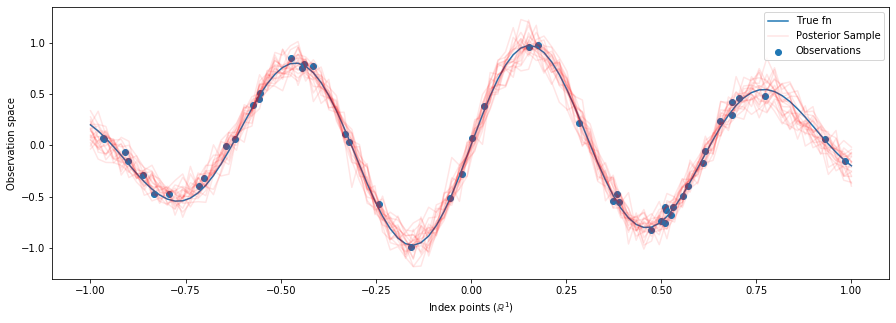

In [ ]:
noise=np.random.normal(0., .05, 50)
x = np.linspace(-1., 1., 100)[..., np.newaxis].astype(np.float32)
x_obs = np.random.uniform(-1., 1., 50)[..., np.newaxis].astype(np.float32)
y_obs = (f(x_obs) + noise).astype(np.float32)
num_samples = 20

model = GPRExpQuad()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(1000):
    with tf.GradientTape() as tape:
        l = model.nll_for_train(x_obs, y_obs)
    g = tape.gradient(l, model.trainable_variables)
    optimizer.apply_gradients(zip(g, model.trainable_variables))
    if i%100 == 0:
        print('loss: %.2f'%l.numpy())
samples = model.gprm(x_obs,y_obs,x).sample(num_samples)
plot_gp_samples(x, x_obs, y_obs, samples, num_samples)

__Numerical Approximations.__ A potential problem in the application of Bayesian inference is the integration necessary to compute the normalising constant of the posterior distribution, i.e. the marginal likelihood.
For most interesting models for machine learning, the required
integrals become analytically intractable, and
good approximations are not easily derived. In the next subsections we briefly review some common approximation techniques such as Variational Inference or Markov chain Monte Carlo methods for estimating posterior distributions.

### Variational Inference


Variational Inference (VI) is a method for approximating probability densities through optimization.

__How is it done.__ Consider a family of distributions denoted $q(z|\phi)$ parametrised by vector $\phi \in \Phi$ which approximate $p(z|x)$. The idea of VI is to find the best approximation of the posterior via:

$$\phi_* = arg min_{\phi \in \Phi} KL \left(q(z|\phi) || p(z | x) \right)$$

i.e. find $\phi_*$ which minimises the Kullback Leibler divergence, which in short is an asymmetric measure of the difference in two probability distributions. In other words, the steps for turning the inference problem into an optimization problem are:

- Posit a family of approximate densities $Q$ over the latent variables $\phi$ (parameters we want to estimate,  as the weights of a network, for example).

- Try to find the member of that family that minimizes the Kullback-Leibler
divergence to the exact posterior

- Approximate the posterior with the optimized member of the family $q^*$

Unfortunately, we can't really compute the KL divergence because it involves the posterior. Instead, the problem is changed to maximising what is known as the evidence lower bound (ELBO).

__ELBO Derivation.__

$$KL(q(z|\phi)||p(z|x))=\int_{-\infty}^{\infty} q(z|\phi)\log\left(\frac{q(z|\phi)}{p(z|x)}\right)dz = ... \
= 𝔼_{q(z|\phi)}(\log(q(z|\phi))−𝔼_{q(z|\phi)}(\log(p(z,x)))+\log(p(x))$$

From where:
$$\log(p(x)) = KL(q(z|\phi)||p(z|x)) + 𝔼_{q(z|\phi)}(\log(p(z,x))) - 𝔼_{q(z|\phi)}(\log(q(z|\phi))$$

Noting that 
$$KL(q(z|\phi)||p(z|x)) \geq 0$$

we obtain a lower bound for the evidence (ELBO):

$$\log(p(x)) \geq 𝔼_{q(z|\phi)}(\log(p(z,x))) - 𝔼_{q(z|\phi)}(\log(q(z|\phi)) = ELBO(\phi)$$

From a practical perspective, variational inference methods can be found in TensorFlow Probability as well [link](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/vi). For instance and continuing the last example of Gaussian Processes, we can construct our variational GP Distribution instance
with the help of [tfd.VariationalGaussianProcess](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/VariationalGaussianProcess).




In [ ]:
class VGPR(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        num_inducing_points_ = 20
        self.amplitude = tf.Variable(np.float64(0.54), name='amplitude')
        self.length_scale = tf.Variable(np.float64(0.54), name='length_scale')
        self.inducing_index_points = tf.Variable(np.linspace(-10., 10., num_inducing_points_)[..., np.newaxis].astype(np.float64), name='inducing_index_points')
        self.variational_inducing_observations_loc = tf.Variable(np.zeros([num_inducing_points_], dtype=np.float64), name='variational_inducing_observations_loc')
        self.variational_inducing_observations_scale = tf.Variable(np.eye(num_inducing_points_, dtype=np.float64), name='variational_inducing_observations_scale')
        self.observation_noise_variance = tf.Variable(np.float64(.54), name='obs_noise_variance')

    @property
    def kernel(self):
        return psd_kernels.ExponentiatedQuadratic(amplitude=tf.math.softplus(self.amplitude), 
                                                  length_scale=1e-5 + tf.math.softplus(self.length_scale))

    def vgp(self, x_obs, y_obs, x, batch_size, num_training_points):
        self.vi_gp = tfd.VariationalGaussianProcess(
            self.kernel,
            index_points=x,
            inducing_index_points=self.inducing_index_points,
            variational_inducing_observations_loc=self.variational_inducing_observations_loc,
            variational_inducing_observations_scale=self.variational_inducing_observations_scale,
            observation_noise_variance=tf.math.softplus(self.observation_noise_variance))
        return self.vi_gp.variational_loss(
            observations=y_obs,
            observation_index_points=x_obs,
            kl_weight=float(batch_size) / float(num_training_points))

In [ ]:
def plot_gp_vi(samples, mean, x, x_obs, y_obs, inducing_index_points, variational_loc):
    plt.figure(figsize=(15, 5))
    plt.scatter(inducing_index_points[..., 0], variational_loc, marker='x', s=50, color='k', zorder=10)
    plt.scatter(x_obs[..., 0], y_obs, color='#00ff00', zorder=9)
    plt.plot(x, mean, color='k')
    plt.plot(x, f(x), color='b')
    plt.plot(np.tile(x, 50), samples.T, color='r', alpha=.1)

loss: 107.36
loss: 39.68
loss: 3.04
loss: -18.42
loss: -39.21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  import sys


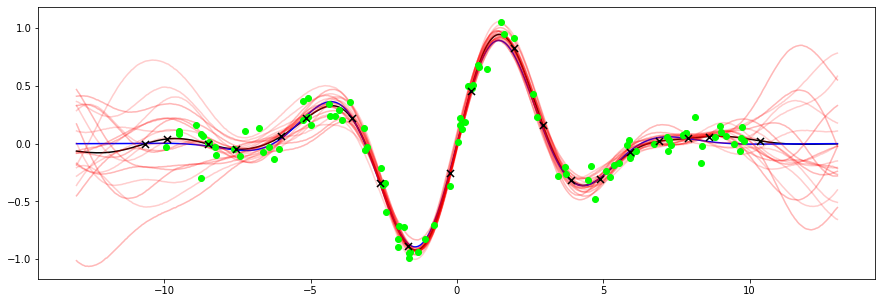

In [ ]:
f = lambda x: np.exp(-x[..., 0]**2 / 20.) * np.sin(1. * x[..., 0])

batch_size = 64
num_training_points = 100
true_observation_noise_variance = np.float64(1e-1) ** 2
x_obs = np.random.uniform(-10., 10., [num_training_points, 1]).astype(np.float64)
noise = np.random.normal(0., np.sqrt(true_observation_noise_variance), [num_training_points]).astype(np.float64)
y_obs = (f(x_obs) + noise).astype(np.float64)
x = np.linspace(-13, 13, 500, dtype=np.float64)[..., np.newaxis].astype(np.float64)

model = VGPR()
optimizer = tf.keras.optimizers.Adam()
for i in range(5000):
    batch_idxs = np.random.randint(num_training_points, size=[batch_size])
    x_obs_batch = x_obs[batch_idxs, ...]
    y_obs_batch = y_obs[batch_idxs]
    with tf.GradientTape() as tape:
        l = model.vgp(x_obs_batch, y_obs_batch, x, batch_size, num_training_points)
    g = tape.gradient(l, model.trainable_variables)
    optimizer.apply_gradients(zip(g, model.trainable_variables))
    if i%1000 == 0:
        print('loss: %.2f'%l.numpy())
samples = model.vi_gp.sample(num_samples)
mean = model.vi_gp.mean()
plot_gp_vi(samples.numpy(), mean, x, x_obs, y_obs, model.inducing_index_points.numpy(), model.variational_inducing_observations_loc.numpy())

### Monte Carlo Methods


The other well known methods for computing approximately a posterior distribution corresponds to the Monte Carlo ones (MC). MC finds approximate solutions through random sampling, that is, it approximates the probability of an outcome by running multiple trails.

In order to understand better how MC works, let us solve the next exercise.

__Ex: Estimating the value of pi using Monte Carlo__

In [ ]:
square_size = 1
points_inside_circle = 0
points_inside_square = 0
sample_size = 1000
arc = np.linspace(0, np.pi/2, 100)

def generate_points(size):
    x = random.random()*size
    y = random.random()*size
    return (x, y)

def is_in_circle(point, size):
    return math.sqrt(point[0]**2 + point[1]**2) <= size

def compute_pi(points_inside_circle, points_inside_square):
    return 4 * (points_inside_circle / points_inside_square)

plt.axes().set_aspect('equal')
plt.plot(1*np.cos(arc), 1*np.sin(arc))


for i in range(sample_size):
     point = generate_points(square_size)
     plt.plot(point[0], point[1], 'c.')
     points_inside_square += 1
        
     if is_in_circle(point, square_size):
         points_inside_circle += 1

print("Approximate value of pi is {}"
.format(compute_pi(points_inside_circle, points_inside_square)))

Inside the MC family of methods, Markov chain Monte Carlo (MCMC) are the most relevant ones. The basic idea here is to simulate a Markov chain
$h(1),..., h(m),...$ , which is designed to converge to the posterior distribution $f(h|D)$. After convergence we simply need to obtain samples to draw the
posterior distribution or compute any basic statistic of interest.

Check out this [great animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) by Chi Feng to see how different MCMC algorithms sample the posterior distribution

All the methods of TFP concerning MCMC can be found [here](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/mcmc)

In the next exercise, we will solve our Gaussian Processes example with the help of [tfp.mcmc.sample_chain](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_chain), [tfp.mcmc.HamiltonianMonteCarlo](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo) and [tfp.mcmc.TransformedTransitionKernel](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransformedTransitionKernel)
methods.

In [ ]:
class gp_hmcmc():

    def __init__(self, x_obs, y_obs, x, num_results=200):
        
        self.num_results = num_results 
        self.x_obs = x_obs
        self.y_obs = y_obs
        self.x = x

        self.initial_chain_states = [
            1e-1 * tf.ones([], dtype=np.float64, name='init_amplitude'),
            1e-1 * tf.ones([], dtype=np.float64, name='init_length_scale'),
            1e-1 * tf.ones([], dtype=np.float64, name='init_obs_noise_variance')]
        
        self.unconstraining_bijectors = [
            tfp.bijectors.Softplus(),
            tfp.bijectors.Softplus(),
            tfp.bijectors.Softplus(),]

    def joint_log_prob(self, amplitude, length_scale, noise_variance):

        # Hyperparameter Distributions.
        rv_amplitude = tfd.LogNormal(np.float64(0.), np.float64(1))
        rv_length_scale = tfd.LogNormal(np.float64(0.), np.float64(1))
        rv_noise_variance = tfd.LogNormal(np.float64(0.), np.float64(1))

        gp = tfd.GaussianProcess(
          kernel=psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),
          index_points=self.x_obs,
          observation_noise_variance=noise_variance)

        return (rv_amplitude.log_prob(amplitude) + 
                rv_length_scale.log_prob(length_scale) +
                rv_noise_variance.log_prob(noise_variance) +
                gp.log_prob(self.y_obs))

    def unnormalized_log_posterior(self, amplitude, length_scale, noise_variance):
        return self.joint_log_prob(amplitude, length_scale, noise_variance)
    
    def mcmc(self, num_burnin_steps=8000, 
             num_steps_between_results=3, 
             step_size=[np.float64(.15)], 
             num_leapfrog_steps=3):
        
        return tfp.mcmc.sample_chain(
            num_results=self.num_results,
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=num_steps_between_results,
            current_state=self.initial_chain_states,
            kernel=tfp.mcmc.TransformedTransitionKernel(
                inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=self.unnormalized_log_posterior,
                    step_size=step_size,
                    num_leapfrog_steps=num_leapfrog_steps),
                bijector=self.unconstraining_bijectors))

    def gprm(self):
        [amplitudes, length_scales, observation_noise_variances], kernel_results = self.mcmc()
        kernel = psd_kernels.ExponentiatedQuadratic(amplitudes, length_scales)
        return tfd.GaussianProcessRegressionModel(
            kernel=kernel,
            index_points=self.x,
            observation_index_points=self.x_obs,
            observations=self.y_obs,
            observation_noise_variance=observation_noise_variances)

/root/.local/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


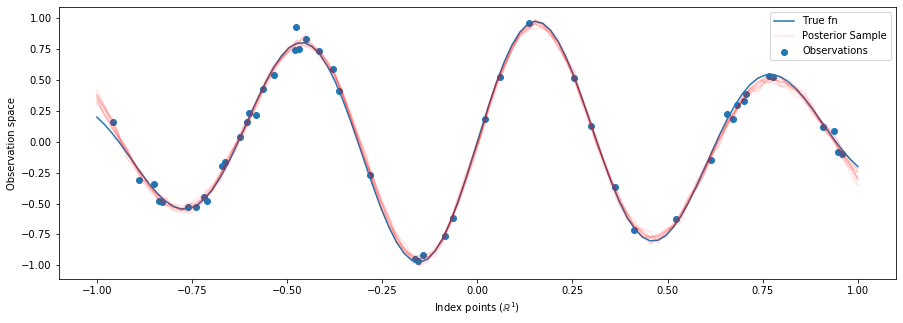

In [ ]:
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
x_obs = np.random.uniform(-1., 1., 50)[..., np.newaxis]
noise=np.random.normal(0., .05, 50)
y_obs=np.random.normal(f(x_obs), .05)
x = np.linspace(-1., 1., 100)[..., np.newaxis]
num_samples = 10

hmcmc = gp_hmcmc(x_obs, y_obs, x)
gp = hmcmc.gprm()
samples = gp.sample(num_samples)
plot_gp_samples(x, x_obs, y_obs, np.mean(samples, axis=0), num_samples)

## Bayesian Deep Learning 

So far we have introduced the building blocks to deal with uncertainty in a general framework. Now it is time to apply all of the Bayesian Inference machinery we learnt about before to the problem of neural networks.

__Main definition.__ A Bayesian neural network is a neural network with a prior distribution on its weights. This means that, in contrast with any convential (non-Bayesian) neural network, BNNs are interested not only in the optimal values of the network's parameters -- weights and biases -- but also in the distribution associated with them. Thanks to these distributions we could have a certain level of confidence about the network predictions.

_The  idea  behind  Bayesian  neural  networks is to cast the task of training a network as a problem of inference, which is solved using Bayes’ theorem. The latter theorem is mainly used to assign a probability density to each point in the parameter space of the neural network._

__Network training.__ A training iteration consists of a forward-pass and a backward-pass. During a forward pass a single sample is drawn from a variational posterior distribution. It is used to evaluate the approximate cost function. During a backward-pass, gradients of the parameters are calculated via backpropagation so that their values can be updated by an optimizer.

Since a forward pass involves a stochastic sampling step we have to apply the so-called [re-parameterization trick](http://gregorygundersen.com/blog/2018/04/29/reparameterization/) for backpropagation to work.


__Use case.__ Let us start our discussion of BDL with the simple case of Regression. In the process we will learn about the types of uncertainties inherent in regression predictions, namely the aleatoric uncertainty and the epidemic uncertainty.

__Auxiliar code for creating toy datasets__

In [ ]:
def s(x, x_range):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    
def get_simple_data(w0=0.125, b0=5.0, n=150, n_tst=150, n_samples=150, x_range=[-20, 60], seed=27):
    np.random.seed(seed)
    x_domain = np.linspace(*x_range, n_samples)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x, x_range)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    y_tst = (w0 * x_tst + b0)
    x_tst = x_tst[..., np.newaxis]
    return x, x_tst, y, y_tst

In [ ]:
def get_yal_data():
    x_train = np.linspace(0, 1, 20)
    x_train = x_train * 12 - 6
    y_train = x_train * np.sin(x_train)
    x_train = x_train[..., np.newaxis]
    x_test = np.linspace(0, 1, 100)
    x_test = x_test * 20 - 10
    x_test = x_test[..., np.newaxis]
    y_test = x_test * np.sin(x_test)
    return x_train, x_test, y_train, y_test

In [ ]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon
    
def get_sin_data():
    train_size = 32
    noise = 1.0
    x_train = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
    y_train = f(x_train, sigma=noise)
    y_test = f(x_train, sigma=0.0)
    return x_train, x_train, y_train, y_test

In [ ]:
def get_hard_data(seed=10):
    np.random.seed(seed)
    noise = [1, 1, 2, 4]
    x_piece_1 = np.linspace(0, 1. * np.pi, 10)
    x_piece_2 = np.linspace(2.9 * np.pi, 3.7 * np.pi, 20)
    x_piece_3 = np.linspace(3.8 * np.pi, 4.2 * np.pi, 20) # 2.9, 4.2
    x_pieces = (x_piece_1, x_piece_2, x_piece_3)
    x_train = np.concatenate(x_pieces, axis=0)
    y_train = np.concatenate(tuple(piece * np.sin(piece) + np.random.normal(-noise[i], noise[i], len(piece)) for i, piece in enumerate(x_pieces)), axis=0)

    x_test = np.linspace(-np.pi, 5.5 * np.pi, 1000)
    y_test = x_test * np.sin(x_test)
    
    return x_train, x_test, y_train, y_test    

__Ex. Select the simple dataset__

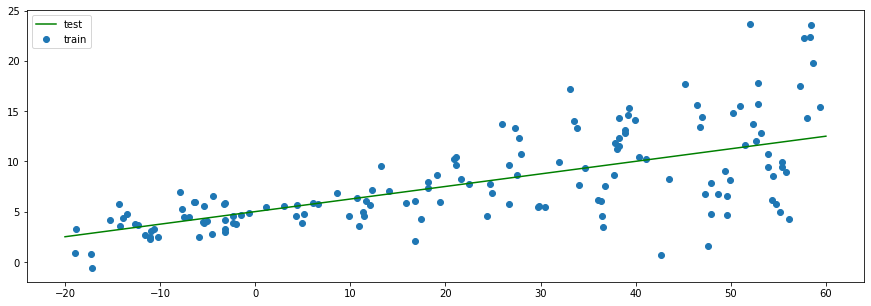

In [ ]:
x_train, x_test, y_train, y_test = get_simple_data()
plt.figure(figsize=(15, 5))
plt.plot(x_test, y_test, color='g', label='test')
plt.scatter(x_train, y_train, label='train')
plt.legend(loc='best')

__Auxiliar functions for plotting purposes.__

In [ ]:
def plot_dropout(model, x_train, y_train, x_test, y_test, n_posterior_samples=1, uncertainty=False):
    samples = [model.predict(x_test) for _ in range(n_posterior_samples)]
    m = np.mean(samples, axis=0).flatten() # predictive mean
    v = np.var(samples, axis=0).flatten() # predictive variance

    plt.figure(figsize=(15, 5))
    plt.plot(x_train, y_train, 'or', label='train')
    plt.plot(x_test, y_test, 'g', label='real')
    plt.plot(x_test, m, 'gray')
    plt.fill_between(np.squeeze(x_test), m - 2*v**0.5, m + 2*v**0.5, 
                     color='lightblue', alpha=0.5) 

In [ ]:
def plot_uncertainty(model, x_train, y_train, x_test, y_test, n_posterior_samples=1, 
                     uncertainty=False, intervals=False, ylim=None):
    # sample posterior
    yhats = [model(x_test) for _ in range(n_posterior_samples)] 
    
    plt.figure(figsize=(15, 5))
    plt.plot(x_train, y_train, 'or', label='train')
    plt.plot(x_test, y_test, 'g', label='real')
    # plot means for each posterior sample
    if uncertainty:
        for i, yhat in enumerate(yhats):
            plt.plot(x_test, yhat.mean(), 
                     'gray', linewidth=0.5, alpha=0.5, 
                     label=f"{n_posterior_samples} sample means" if i==0 else None)
            if intervals:
                plt.fill_between(np.squeeze(x_test), 
                                 np.squeeze(yhat.mean() - 2 * yhat.stddev() ** 0.5), 
                                 np.squeeze(yhat.mean() + 2 * yhat.stddev() ** 0.5), 
                                 color='lightblue', alpha=0.5) # plot two std (95% confidence)

        # plot overall mean
        yhats_mean = sum(yh.mean() for yh in yhats) / len(yhats)
        plt.plot(x_test, yhats_mean, 'darkred', linewidth=2, label="aggregate mean")
        
    else:
        for i, yhat in enumerate(yhats):
            plt.plot(x_test, yhat, 'gray', 
                     label=f"estimated" if i==0 else None)
        

    if ylim is not None:
        plt.gca().set_ylim(ylim[0], ylim[1])
    plt.legend()

In [ ]:
def neg_log_lik(y, rv_y):
    """Evaluate negative log-likelihood of a random variable `rv_y` for data `y`"""
    return -rv_y.log_prob(y)

### Preliminars: tpf.layers

In the following, we will work with the layers below to include uncertainty in our neural network models:

- __DistributionLambda__ is a special Keras layer that uses a Python lambda to construct a distribution conditioned on the layer inputs. Have a look at the following example to understand how it works:

```
layer = tfp.layers.DistributionLambda(lambda t: tfd.Normal(t, 1.))
distribution = layer(2.)
assert isinstance(distribution, tfd.Normal)
distribution.loc
# ==> 2.
distribution.stddev()
# ==> 1.
```

__DenseVariational layer__ enables learning a distribution over its weights using variational inference. This is done by maximizing the ELBO (Evidence Lower BOund) objective, that is a lower bound on $\log P(Y | X)$.

## Case 1: No uncertainty.

We will first implement linear regression and learn point estimates for the parameters w and b

In [ ]:
model_case_1_usual = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))])

# train the model
model_case_1_usual.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
                           loss=losses.mean_squared_error)
h = model_case_1_usual.fit(x_train, y_train, epochs=500, validation_split=.2, verbose=True)

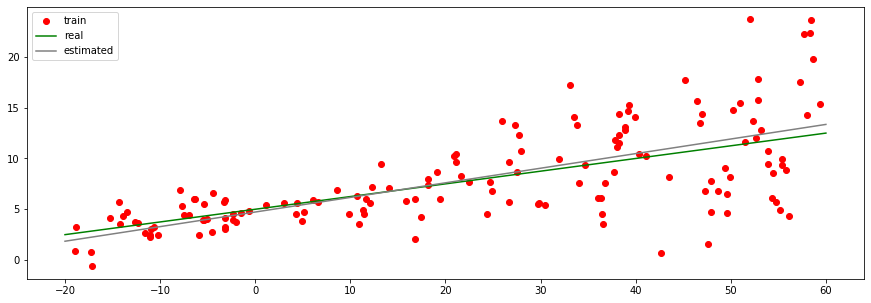

In [ ]:
plot_uncertainty(model_case_1_usual, x_train, y_train, x_test, y_test)

Let us do the same but this time with tfp.layers.DistributionLambda layer:

In [ ]:
# Case 1 revisited
model_case_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,)),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1.0))])

# train the model
model_case_1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                     loss=neg_log_lik)
h = model_case_1.fit(x_train, y_train, epochs=500, validation_split=.2, verbose=True)

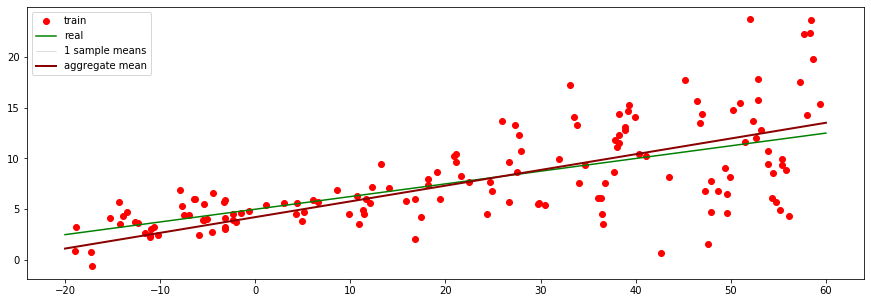

In [ ]:
plot_uncertainty(model_case_1, x_train, y_train, x_test, y_test, 
                 1, True, False)

## Case 2: Aleatoric Uncertainty

Aleatoric uncertainty refers to the unknowns that differ each time data is collected. This kind of uncertainty is associated with the randomness of the process under consideration (or the observations' noise).

From the training data, it is easy to see that:

- There is variability in the $y$ for any particular value of $x$. 
- The variance of $y$ seems to be related to $x$ (e.g. it increases as $x$ does)

Now the model is defined as follows:
- one-dimensional input
- a hidden layer with two nodes
- an output layer that yields a Normal distribution with non-constant variance

$$f(x) \sim N(\mu(x), \sigma(x))$$
 
Where $\mu$ is a linear function, and $\sigma$ is a softplus function. Once again, we use negative log-likelihood as our loss function.



In [ ]:
def normal_scale_uncertainty(t, softplus_scale=0.05):
    """Create distribution with variable mean and variance"""
    ts = t[..., :1]
    return tfd.Normal(loc = ts,
                      scale = 1e-3 + tf.math.softplus(softplus_scale * t[...,1:]))

In [ ]:
model_case_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,)),
    tfp.layers.DistributionLambda(normal_scale_uncertainty)])

model_case_2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05),
                     loss=neg_log_lik)
model_case_2.fit(x_train, y_train, epochs=500, validation_split=.2, verbose=True)

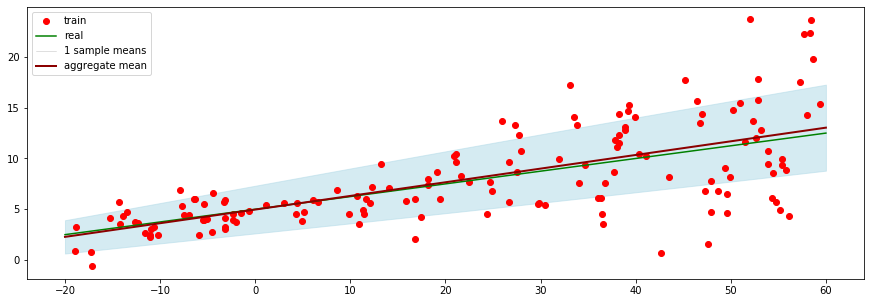

In [ ]:
plot_uncertainty(model_case_2, x_train, y_train, x_test, y_test, 
                 1, True, True)

The plot below suggests a linear relationship between $x$ and $y$, but it shows that as $x$  gets larger, there is more variance in the prediction $y$.

## Case 3: Epistemic Uncertainty

Epistemic uncertainty on the other hand captures our ignorance about the models most suitable to explain the data. The unknown factors in our model, for instance, can be categorised as epistemic uncertainty.

In the previous models, weights were estimated in an exact way. Now, we assume that the weights are normally distributed. 

In order to train the neural network, we use variational inference through the use of the DenseVariational layer.

Now our model has
- a one-dimensional input layer
- a DenseVariational layer, which treats the weights as distributions, rather than numbers
- an output layer that yields a Normal distribution with constant variance

And it has the functional form

$$f(x) \sim N(Wx+B, 1)$$
 
Where $W$ and $B$ are normally-distributed random variables.

In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1e-5 + 
                       tf.nn.softplus(c + t[..., n:])), 
                       reinterpreted_batch_ndims=1)),])

In [ ]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1)),])

In [ ]:
model_case_3 = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, 
                                posterior_mean_field, 
                                prior_trainable,
                                input_shape=(1,)),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1.0))])

model_case_3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
model_case_3.fit(x_test, y_test, epochs=1000, validation_split=.2, verbose=True)

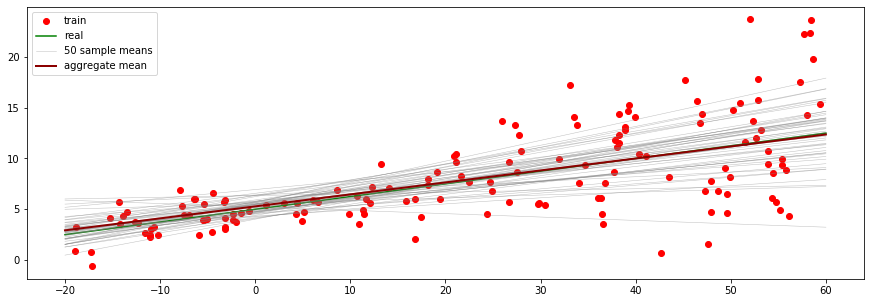

In [ ]:
plot_uncertainty(model_case_3, x_train, y_train, x_test, y_test, 50, True, False)

Each time we call _model_case_3_(x_test), it will give us a different answer. This is because the model is sampling from the distributions imposed on the weights.

## Case 4: Aleatoric & Epistemic Uncertainty

We can include both types of uncertainty in our model. For each of the models considered due to epistemic uncertainty, we can incorporate aleatoric uncertainty.

In [ ]:
model_case_4 = tf.keras.Sequential([
    tfp.layers.DenseVariational(2, 
                                posterior_mean_field,
                                prior_trainable,
                                kl_weight=1/x_train.shape[0]),
    tfp.layers.DistributionLambda(lambda t: normal_scale_uncertainty(t, 0.01))])

model_case_4.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
model_case_4.fit(x_train, y_train, epochs=1000, validation_split=.2, verbose=True)

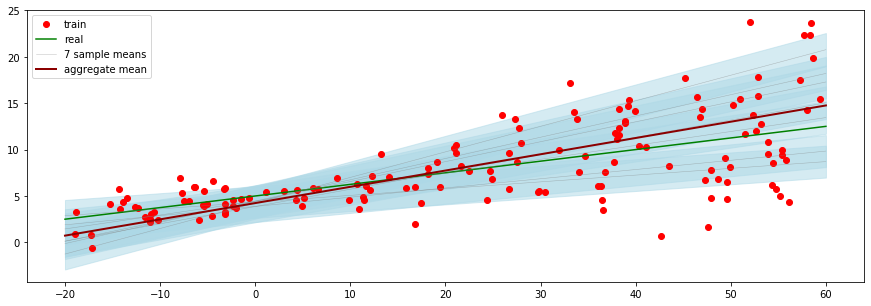

In [ ]:
plot_uncertainty(model_case_4, x_train, y_train, x_test, y_test, 7, True, True)

### Case 5: Functional uncertainty

So far we’ve been assuming that the data follows a line. What if we don’t know the functional relationship between the inputs and the labels, as in the function below?

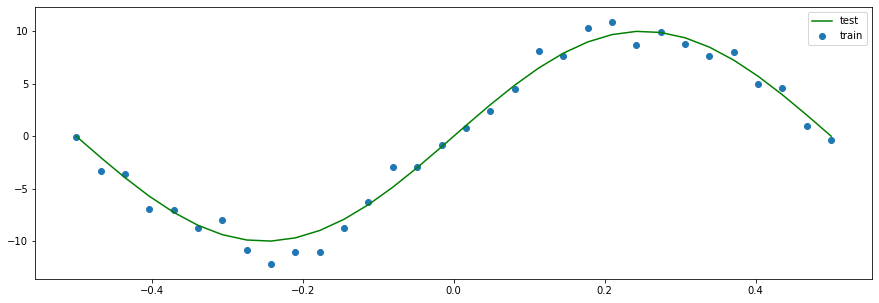

In [ ]:
xf_train, xf_test, yf_train, yf_test = get_sin_data()
plt.figure(figsize=(15, 5))
plt.plot(xf_test, yf_test, color='g', label='test')
plt.scatter(xf_train, yf_train, label='train')
plt.legend(loc='best')

For these cases, TFP provides the [VariationalGaussianProcess](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/VariationalGaussianProcess) layer, which uses a variational approximation to a full Gaussian Process.

As you can see in the following piece of code, the model definition is harder than before: we need to define a new loss function, and there are more parameters to specify. 

In [ ]:
def plot_uncertainty_f(model, x_train, y_train, x_test, y_test, n_posterior_samples=1, 
                     uncertainty=False, intervals=False, ylim=None):
    samples = [model(x_test)[:] for _ in range(n_posterior_samples)]
    m = np.mean(samples, axis=0).flatten() # predictive mean
    v = np.var(samples, axis=0).flatten() # predictive variance

    plt.figure(figsize=(15, 5))
    plt.plot(x_train, y_train, 'or', label='train')
    plt.plot(x_test, y_test, 'g', label='real')
    plt.plot(x_test, m, 'gray')
    plt.fill_between(np.squeeze(x_test), m - 2*v**0.5, m + 2*v**0.5, 
                     color='lightblue', alpha=0.5) 

In [ ]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)
        
        self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name="amplitude"
        )
        
        self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name="length_scale"
        )
    
    def call(self, x):
        return x
    
    @property
    def kernel(self):
        return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5.0 * self._length_scale))

In [ ]:
def variational_loss(y, rv_y):
    return rv_y.variational_loss(y, 
                                 kl_weight=np.array(batch_size, xf_train.dtype) / xf_train.shape[0])

In [ ]:
num_inducing_points = 7
batch_size = 5
inducing_index_points_initializer = np.linspace(-1, 1, num=num_inducing_points, dtype=xf_train.dtype)
model_case_5 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=xf_train.dtype),
    tf.keras.layers.Dense(1, 
                     kernel_initializer="ones", 
                     use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(dtype=xf_train.dtype),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(inducing_index_points_initializer),
        unconstrained_observation_noise_variance_initializer=tf.initializers.constant(5))])

model_case_5.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=variational_loss)
model_case_5.fit(xf_train, yf_train, batch_size=batch_size, epochs=800, verbose=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



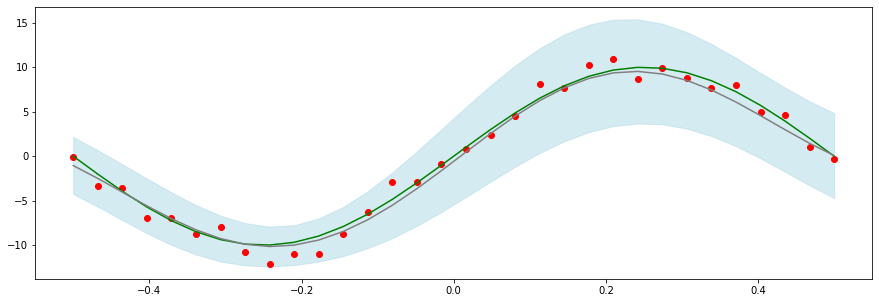

In [ ]:
plot_uncertainty_f(model_case_5, xf_train, yf_train, xf_test, yf_test, 10, True, True)

### Dropout

Dropout (Hinton et al) is a technique used to avoid over-fitting in a model. In essence, dropout zeros out neurons randomly according to a Bernoulli distribution. 

In the context of Bayesian Deep Learning, dropout can be seen as a Gaussian process approximation. In order to get uncertainty estimates from dropout, we just have to apply it both when performing training and prediction steps.


In [ ]:
inputs = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(512, activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.5)(x, training=True)
outputs = tf.keras.layers.Dense(1)(x)

model_case_dropout = tf.keras.Model(inputs, outputs)
model_case_dropout.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model_case_dropout.fit(x_train, y_train, epochs=1000, validation_split=.2, verbose=True)

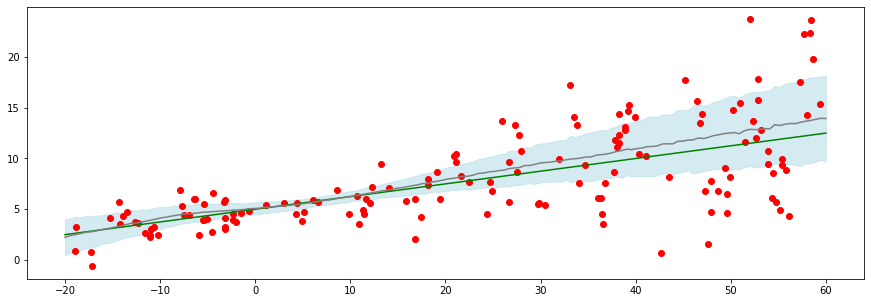

In [ ]:
plot_dropout(model_case_dropout, x_train, y_train, x_test, y_test, 500, True)

__Ex. Play with the yal and hard datasets defined at the beginning of the section__

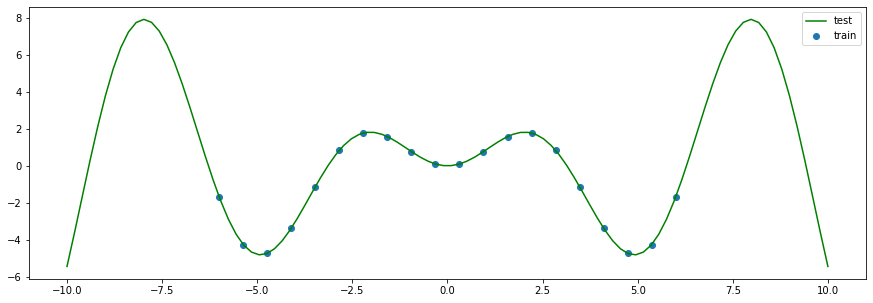

In [ ]:
x_train, x_test, y_train, y_test = get_yal_data()
plt.figure(figsize=(15, 5))
plt.plot(x_test, y_test, color='g', label='test')
plt.scatter(x_train, y_train, label='train')
plt.legend(loc='best')

In [ ]:
def variational_loss(y, rv_y):
    return rv_y.variational_loss(y, 
                                 kl_weight=np.array(batch_size, x_train.dtype) / x_train.shape[0])

In [ ]:
def neg_log_lik(y, rv_y):
    """Evaluate negative log-likelihood of a random variable `rv_y` for data `y`"""
    return -rv_y.log_prob(y)

In [ ]:
def model_gal(aleatoric=False, epistemic=False, dropout=False, num_inducing_points = 40, batch_size = 32):
    if dropout:
        inputs = tf.keras.layers.Input(shape=(1,))
        x = tf.keras.layers.Dense(512, activation="relu")(inputs)
        x = tf.keras.layers.Dropout(0.5)(x, training=True)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x, training=True)
        outputs = tf.keras.layers.Dense(1)(x)
    else:
        inducing_index_points_initializer = np.linspace(-15, 15, num=num_inducing_points, dtype=np.float32)
        inputs = tf.keras.layers.Input(shape=(1,))
        x = (tfp.layers.VariationalGaussianProcess(
            num_inducing_points=num_inducing_points,
            kernel_provider=RBFKernelFn(dtype=x_train.dtype),
            event_shape=[1],
            inducing_index_points_initializer=tf.constant_initializer(inducing_index_points_initializer),
            unconstrained_observation_noise_variance_initializer=tf.initializers.constant(5.))(inputs) if epistemic else tf.keras.layers.Dense(512, activation="relu")(inputs))

        if not epistemic:
            x = tf.keras.layers.Dense(512)(x)
            x = tf.keras.layers.Dense(1)(x)
        outputs = (tfp.layers.DistributionLambda(lambda t: normal_scale_uncertainty(t, 0.05))(x) if aleatoric else 
                   tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1.0))(x))
       
    model = tf.keras.Model(inputs, outputs)
    return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



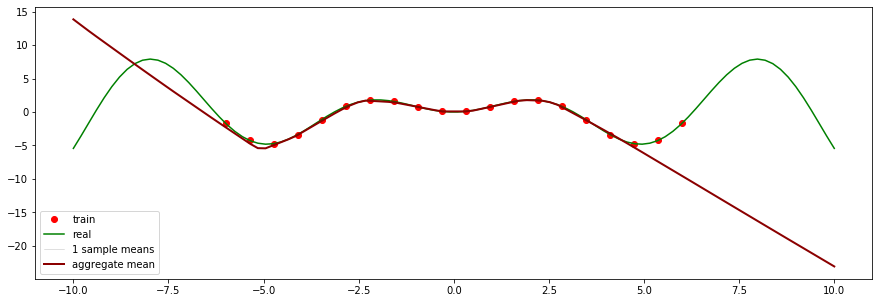

In [ ]:
m_gal = model_gal(aleatoric=False, epistemic=False, dropout=False)
m_gal.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
m_gal.fit(x_train, y_train, epochs=2000, validation_split=.2, verbose=False)
plot_uncertainty(m_gal, x_train, y_train, x_test, y_test, 1, True, False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



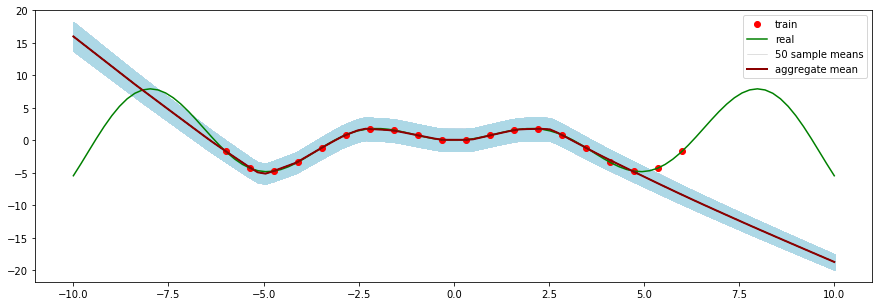

In [ ]:
m_gal = model_gal(aleatoric=True, epistemic=False, dropout=False)
m_gal.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
m_gal.fit(x_train, y_train, epochs=2000, validation_split=.2, verbose=False)
plot_uncertainty(m_gal, x_train, y_train, x_test, y_test, 50, True, True)

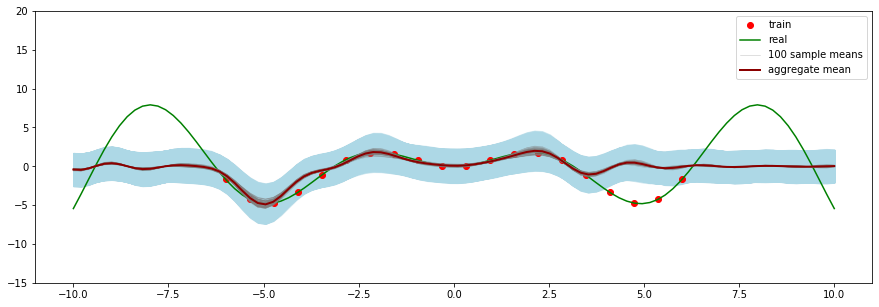

In [ ]:
m_gal = model_gal(aleatoric=False, epistemic=True, dropout=False)
m_gal.compile(optimizer='adam', loss=neg_log_lik)
m_gal.fit(x_train, y_train, epochs=2000, validation_split=.2, verbose=False)
plot_uncertainty(m_gal, x_train, y_train, x_test, y_test, 100, True, True, [-15, 20])

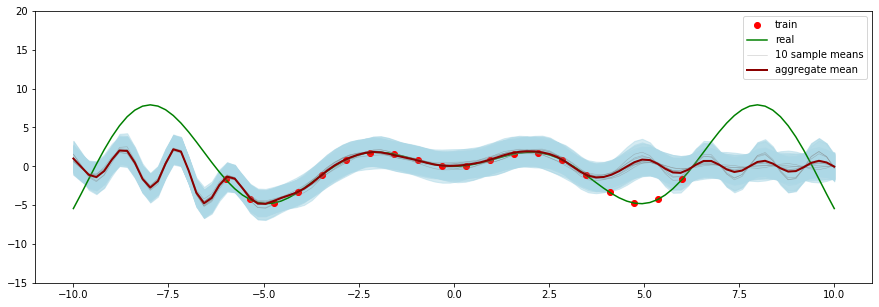

In [ ]:
m_gal = model_gal(aleatoric=True, epistemic=True, dropout=False)
m_gal.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
m_gal.fit(x_train, y_train, epochs=2000, validation_split=.2, verbose=False)
plot_uncertainty(m_gal, x_train, y_train, x_test, y_test, 10, True, True, [-15, 20])

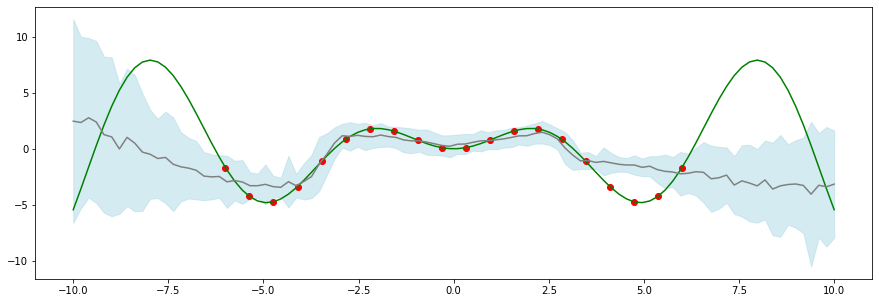

In [ ]:
m_gal = model_gal(aleatoric=False, epistemic=False, dropout=True)
m_gal.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
m_gal.fit(x_train, y_train, epochs=2000, validation_split=.2, verbose=False)
plot_dropout(m_gal, x_train, y_train, x_test, y_test, 50, True)

## Convolutional Bayesian NN

Finally, let us apply the layer [tfp.layers.Convolution2DFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution2DFlipout) to solve MNIST and get uncertainty in our predictions (take a look at the [paper](https://arxiv.org/pdf/1803.04386.pdf) to understand the role played by flipout as an efficient method
for decorrelating the gradients between different examples without biasing the gradient estimates). How does the uncertainty evolve as training step makes higher?

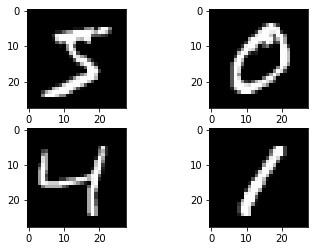

In [ ]:
x_train, x_test, y_train, y_test = read_mnist()
plot_sample_mnist(x_train)

In [ ]:
class bcnn(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.conv2flip_1 = tfp.layers.Convolution2DFlipout(6, kernel_size=5, padding="same", strides=2, activation='relu')
        self.conv2flip_2 = tfp.layers.Convolution2DFlipout(16, kernel_size=5, padding="same", strides=2, activation='relu')
        self.conv2flip_3 = tfp.layers.Convolution2DFlipout(120, kernel_size=5, padding="same", strides=2, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.denseflip_1 = tfp.layers.DenseFlipout(84, activation='relu')
        self.denseflip_2 = tfp.layers.DenseFlipout(10, activation=None)

    def call(self, inputs):
        x = self.conv2flip_1(inputs)
        x = self.conv2flip_2(x)
        x = self.conv2flip_3(x)
        x = self.flatten(x)
        x = self.denseflip_1(x)
        return self.denseflip_2(x)

In [ ]:
def preprocess_mnist_(x_, y_):
  x = tf.cast(x_, tf.float32)/255.
  x = x[..., tf.newaxis]
  y = tf.keras.utils.to_categorical(y_, num_classes=10, dtype='int32')
  return x, y

def create_dataset(x, y): 
  x, y = preprocess_mnist_(x, y) 
  dataset = tf.data.Dataset.from_tensor_slices((x , y)).shuffle(len(x)-1)
  dataset = dataset.batch(32)
  return dataset

In [ ]:
def loss(logits, labels):
    return tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    #return -tf.reduce_mean(tfd.Categorical(logits=logits).log_prob(labels[..., tf.newaxis]))



In [ ]:
@tf.function
def tftrain(x, y, l):
    with tf.GradientTape() as tape:
        logits = model(x)
        kl = sum(model.losses) / l
        loss_value = loss(logits, y) + kl
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

In [ ]:
def plot_bcnn(results, x_test=x_test, indices=[7274, 921, 4699, 8027, 5845, 1028]):
    for i, j in enumerate(indices):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        ax1 = axs[0]
        ax1.imshow(np.squeeze(x_test[j]), cmap=plt.get_cmap('gray'))
        ax2 = axs[1]
        ax2.hist(results[:, i])
        ax2.set_xlim([0, 10])
        plt.show()

In [ ]:
print(y_test[[7274, 921, 4699, 8027, 5845, 1028]])

[5 2 6 8 7 3]


**************************************************
**************************************************
**************************************************
**************************************************

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



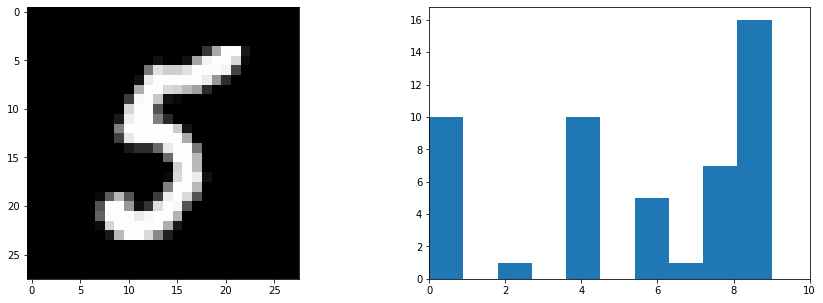

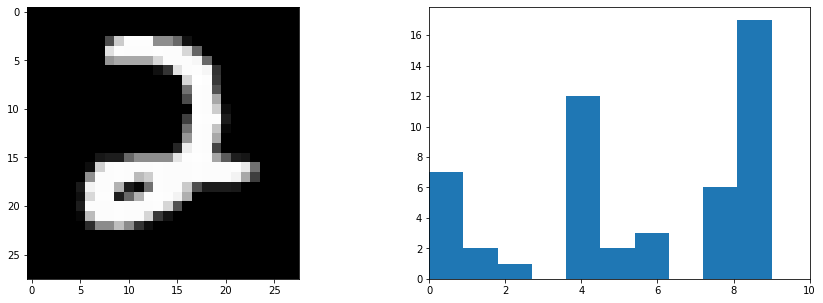

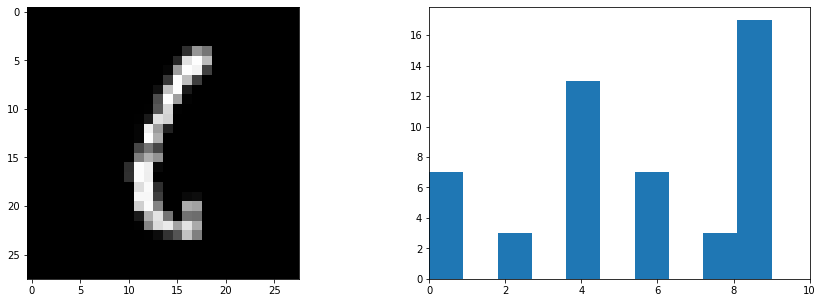

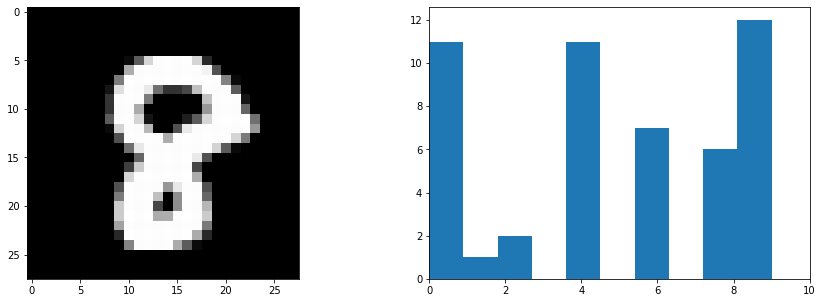

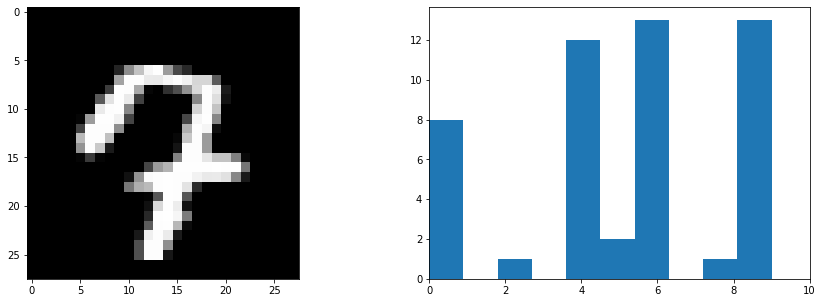

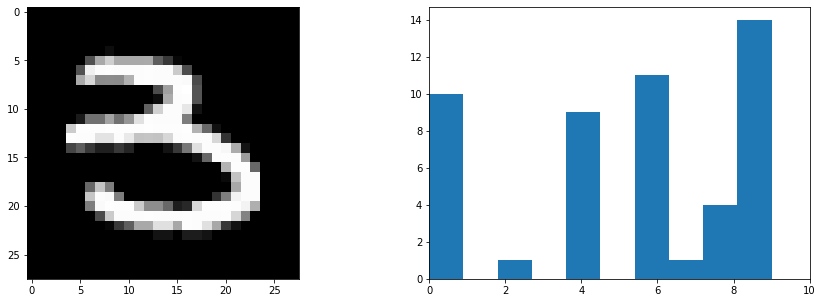

**************************************************
**************************************************
**************************************************
**************************************************


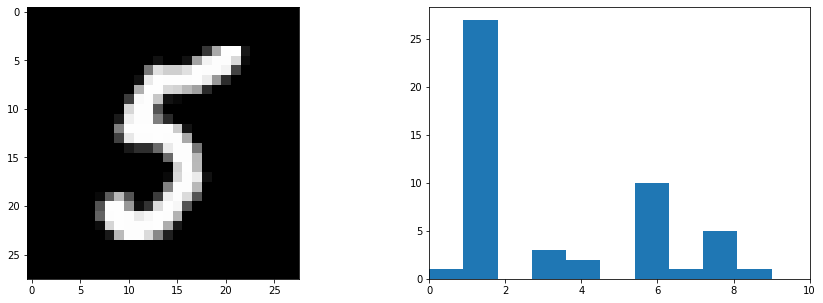

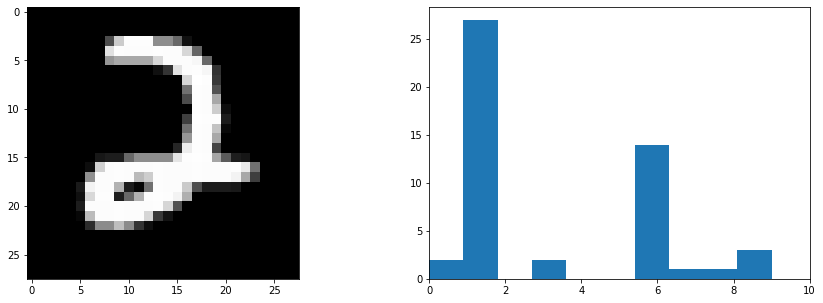

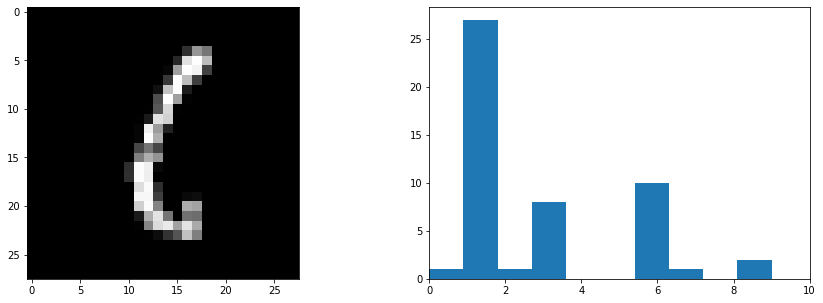

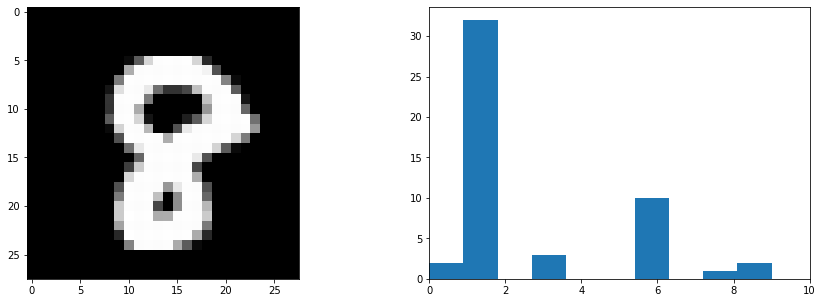

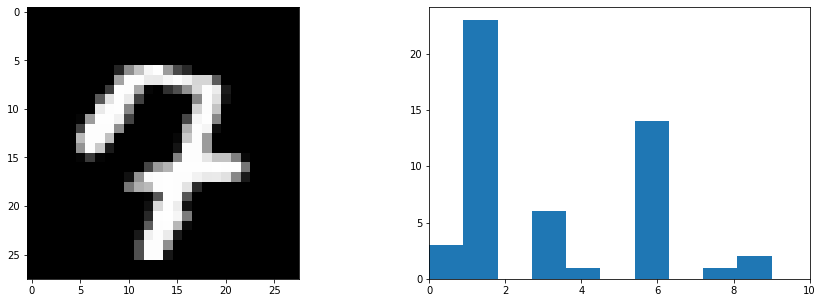

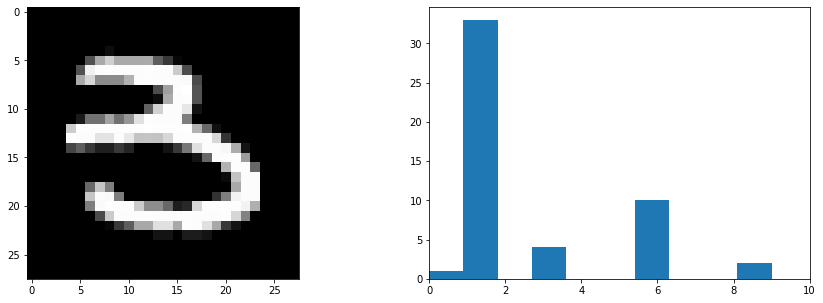

**************************************************
**************************************************
**************************************************
**************************************************


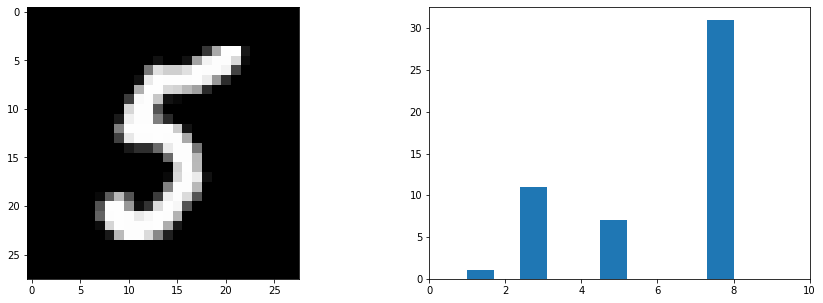

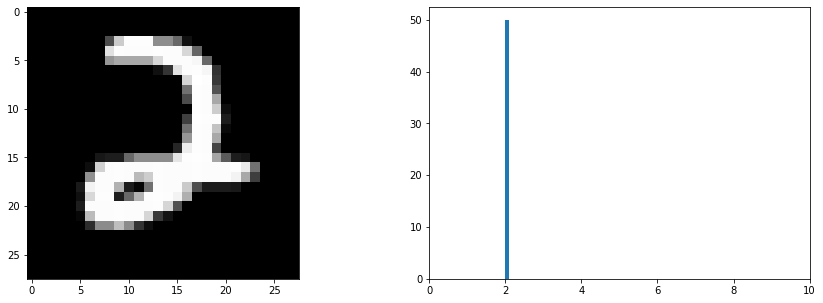

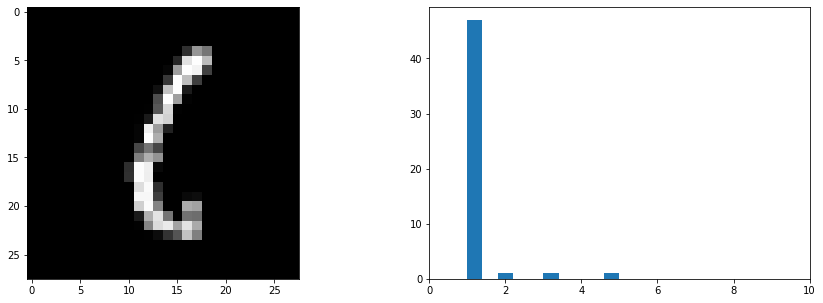

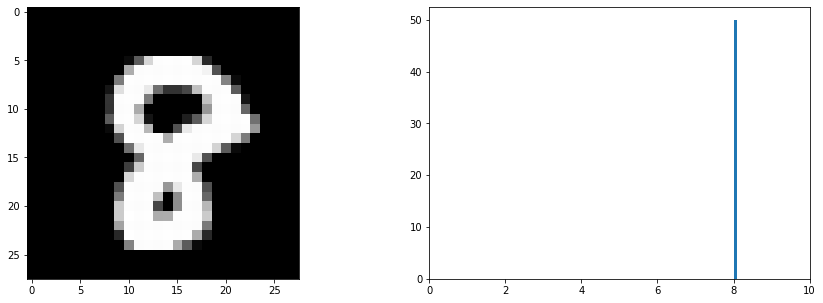

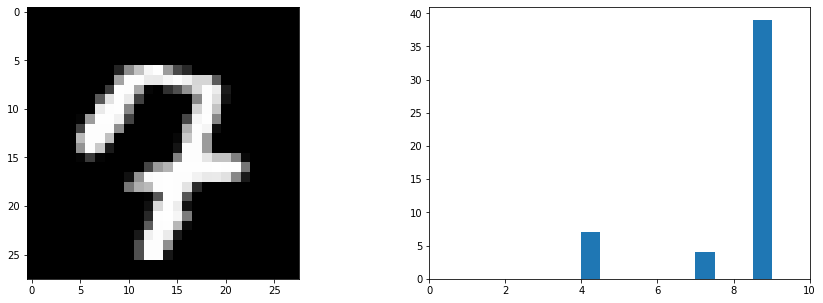

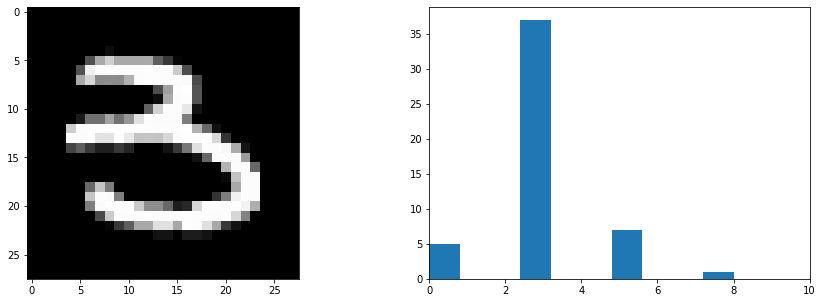

**************************************************
**************************************************
**************************************************
**************************************************


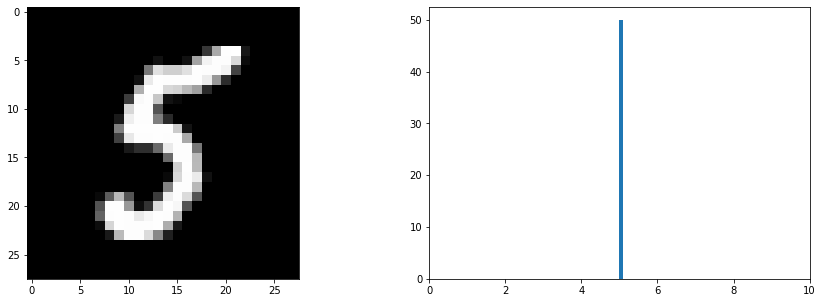

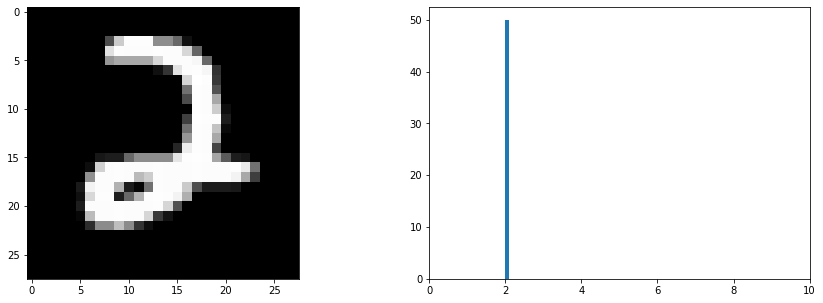

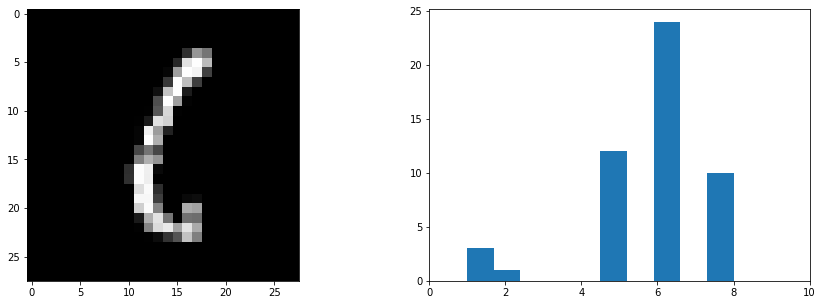

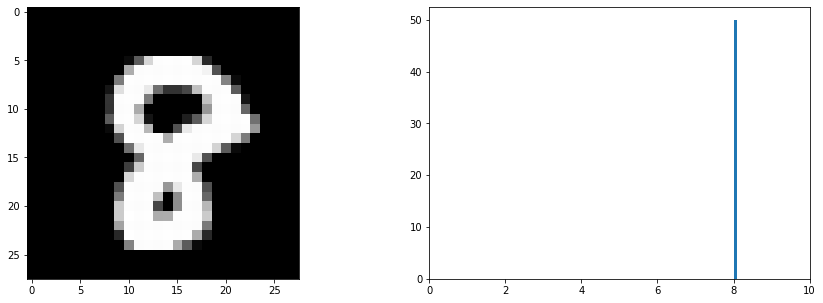

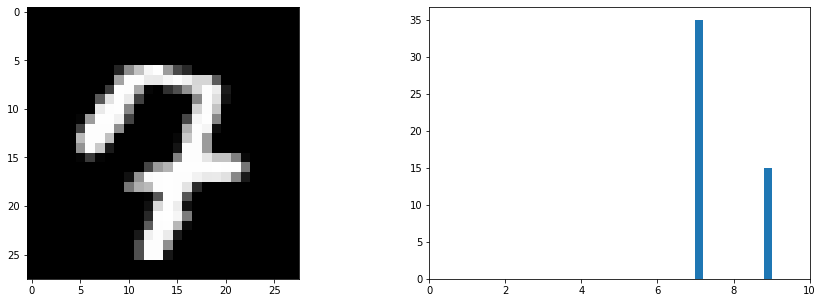

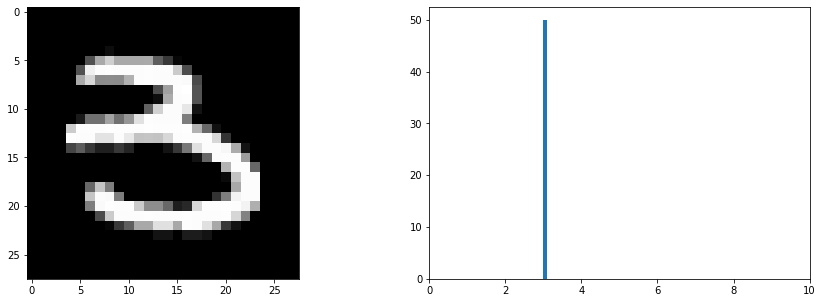

**************************************************
**************************************************
**************************************************
**************************************************


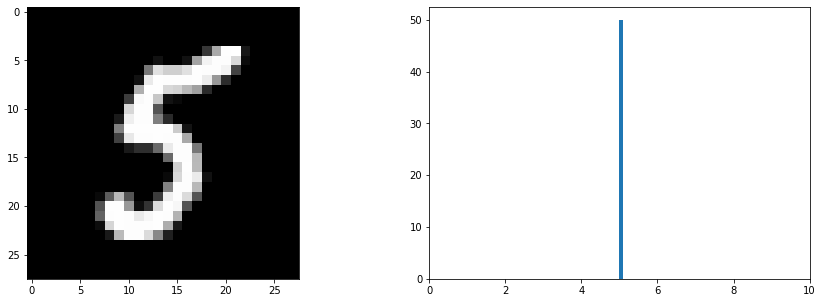

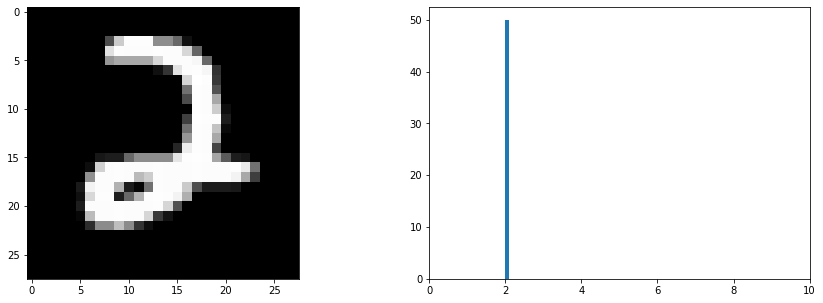

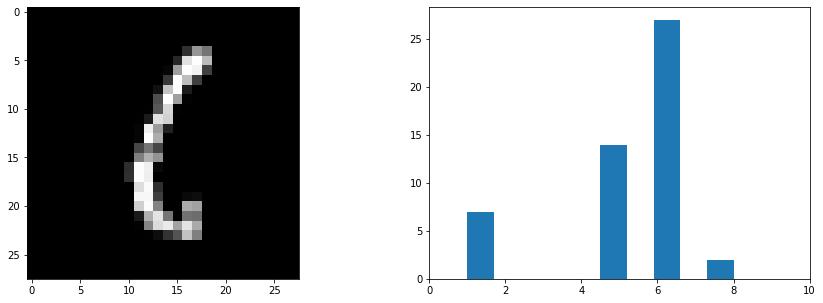

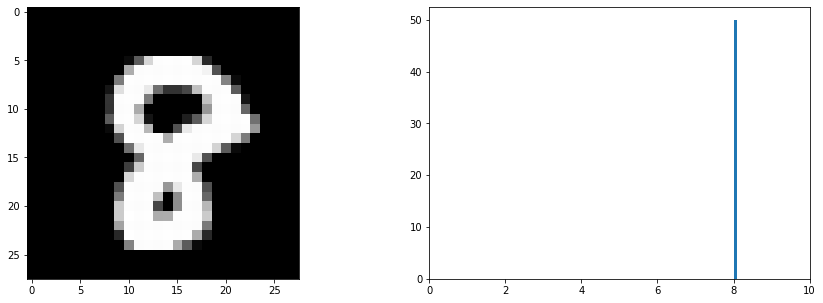

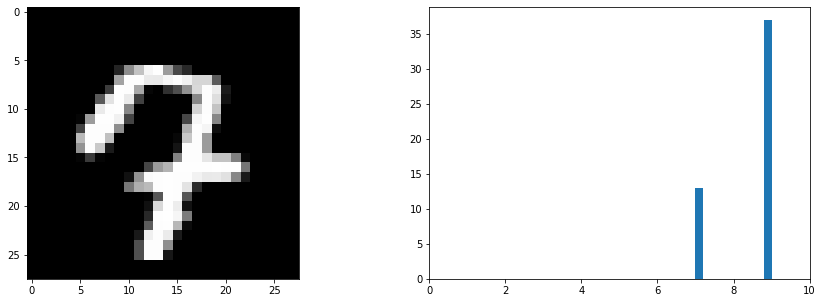

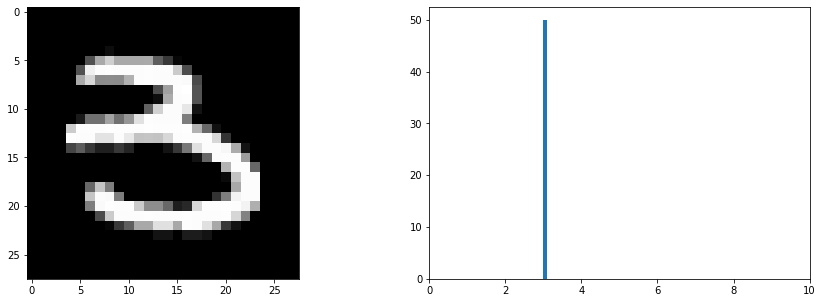

**************************************************
**************************************************
**************************************************
**************************************************


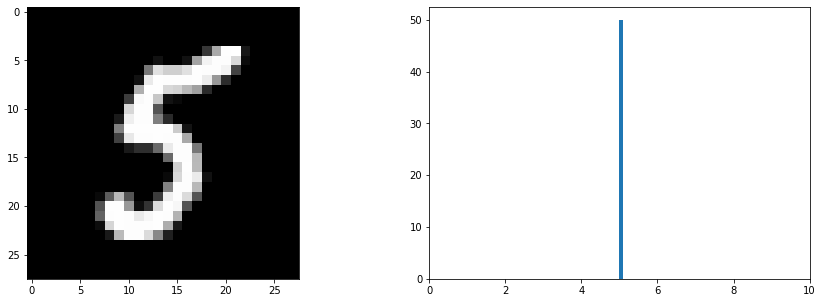

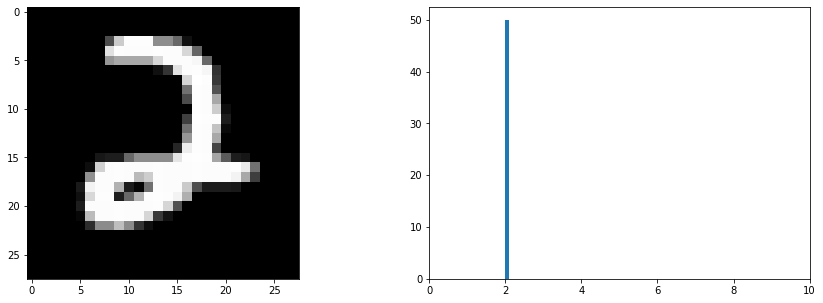

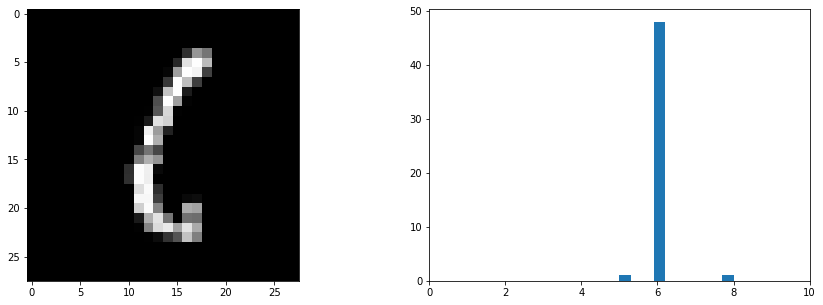

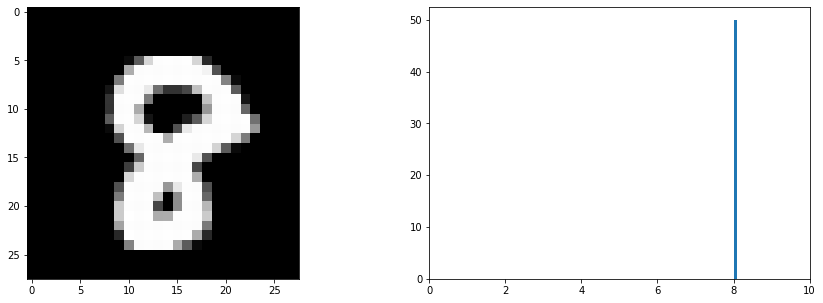

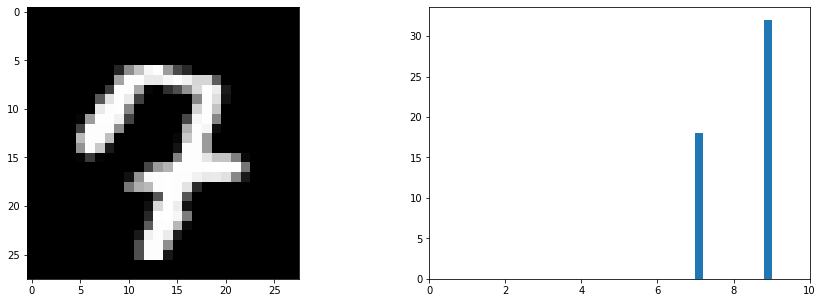

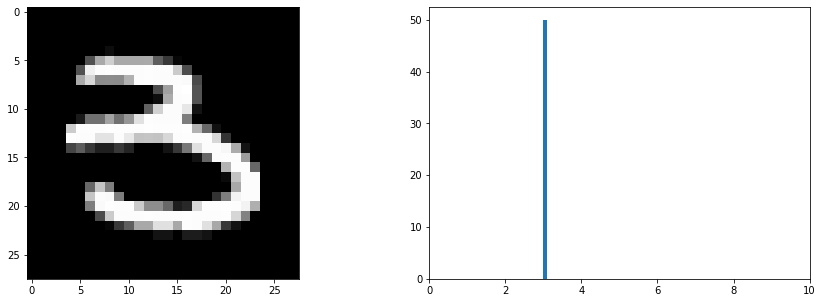

**************************************************
**************************************************
**************************************************
**************************************************


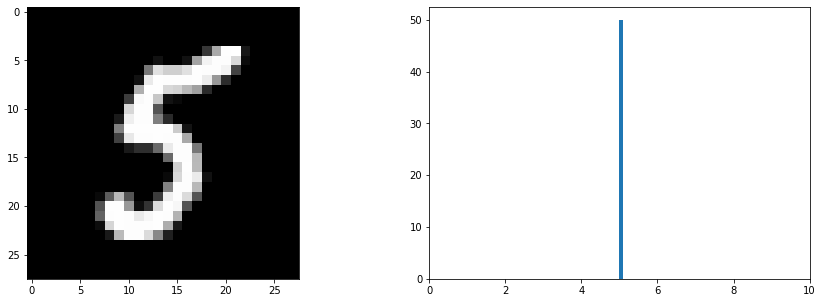

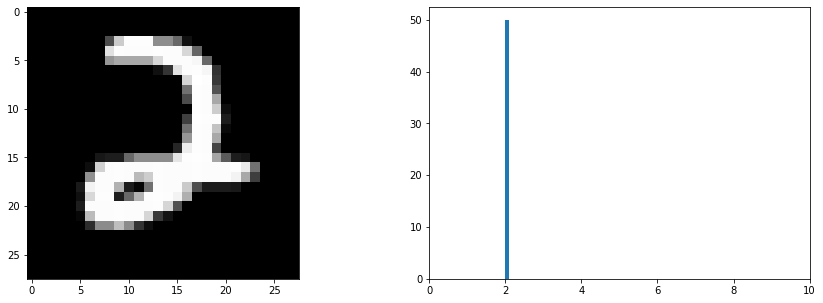

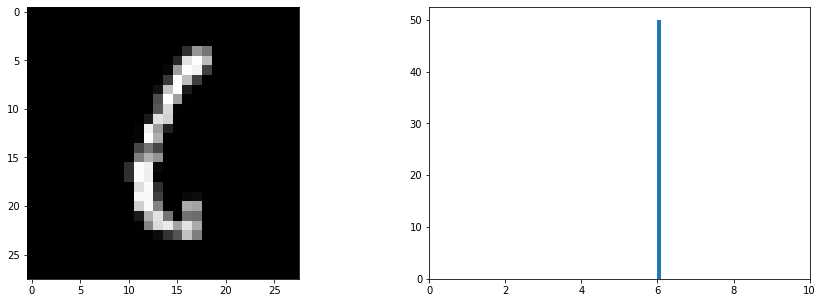

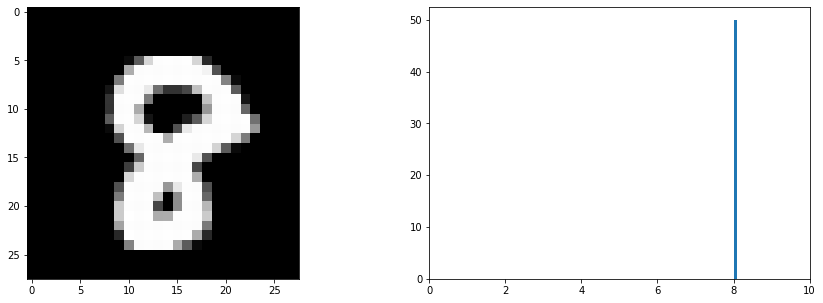

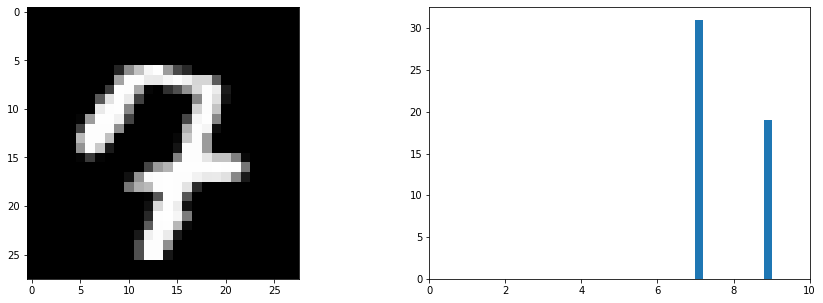

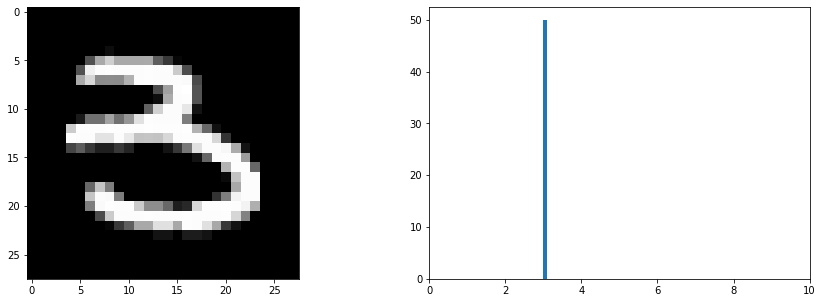

**************************************************
**************************************************
**************************************************
**************************************************


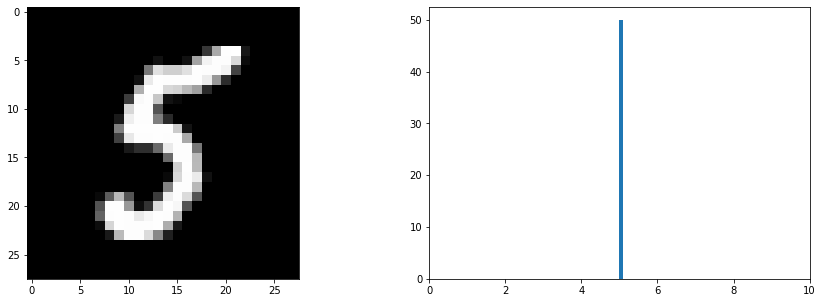

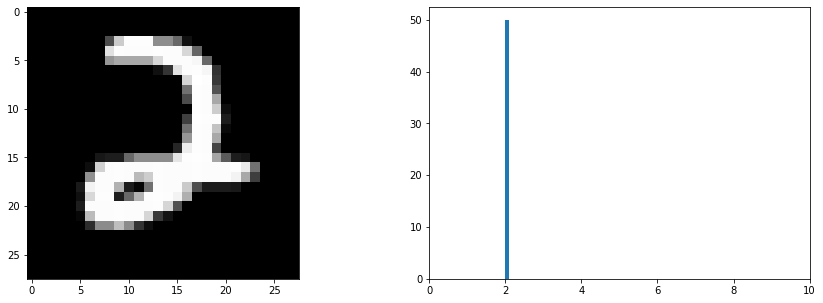

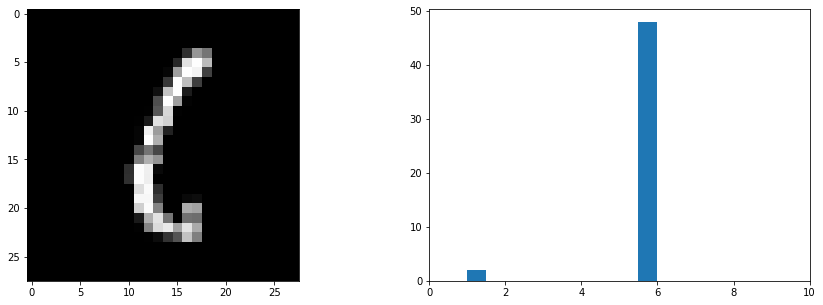

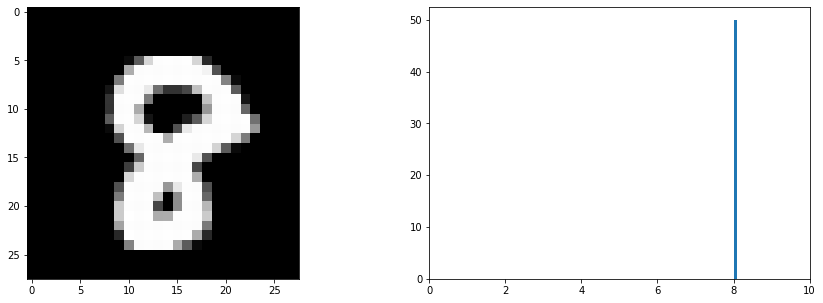

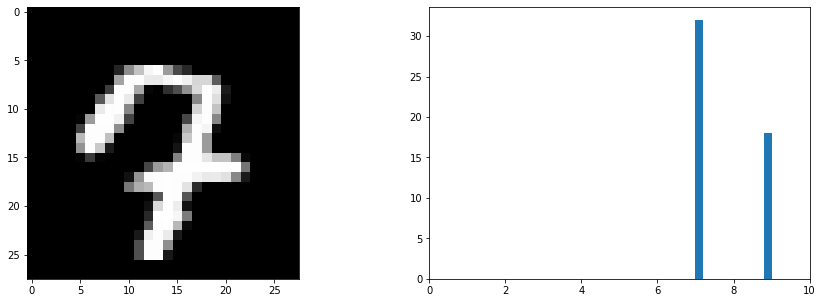

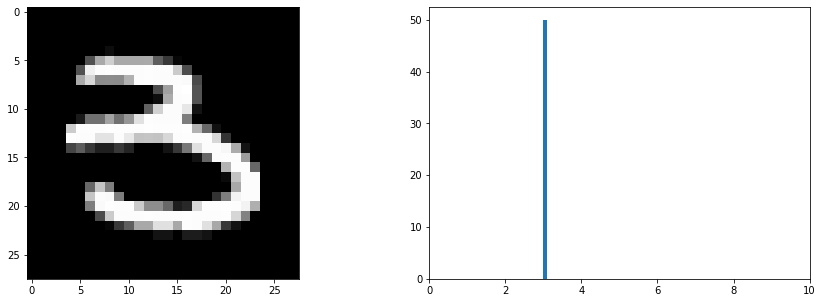

In [ ]:
lr = 0.001
epochs = 2

x_train, x_test, y_train, y_test = read_mnist()
train_dataset = create_dataset(x_train, y_train)
vizdata = x_test[[7274, 921, 4699, 8027, 5845, 1028]]/255.
vizdata = vizdata[..., tf.newaxis]

model = bcnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_dataset):
        loss_ = tftrain(x, y, len(x_train))
        if (i==0) | (i % 500 == 0):
            print('*'*50)
            print('*'*50)
            #print('Epoch: %d, Step: %d, loss: %.2f' % (epoch, i, loss_))
            print('*'*50)
            print('*'*50)
            results = np.array([tf.argmax(model(vizdata), axis=1).numpy().tolist() for i in range(50)])
            plot_bcnn(results)
    

The graphs below show the uncertainties of prediction at different training steps ($\delta=500$). As a conclusion, we can observe how the confidence is improved as the training steps grow.

https://machinelearningmastery.com/bayes-theorem-for-machine-learning/

http://bridg.land/posts/gaussian-processes-1

https://distill.pub/2019/visual-exploration-gaussian-processes/

https://arxiv.org/pdf/1601.00670.pdf

http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb#scrollTo=1XgqrfsSub15

https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

